# Лабораторная работа по главе "Вероятностные модели"

# Вступление

Давайте начнём с того, что вспомним, какими вообще бывают вероятностные модели.

Самые простые вероятностные модели имеют вид

$$y = f_w(x) + \varepsilon,$$

где $\varepsilon$ — шум из некоторого распределения $p$. Эта модель говорит нам следующее:

- в качестве предиктора можно использовать функцию $f_w(x)$ с обучаемыми параметрами $w$;
- возможное отклонение истинного таргета от предсказания подчиняется закону распределения $p$.

Посмотрим на несколько примеров.

In [6]:
import pandas as pd
import numpy as np
import scipy.linalg as sla
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

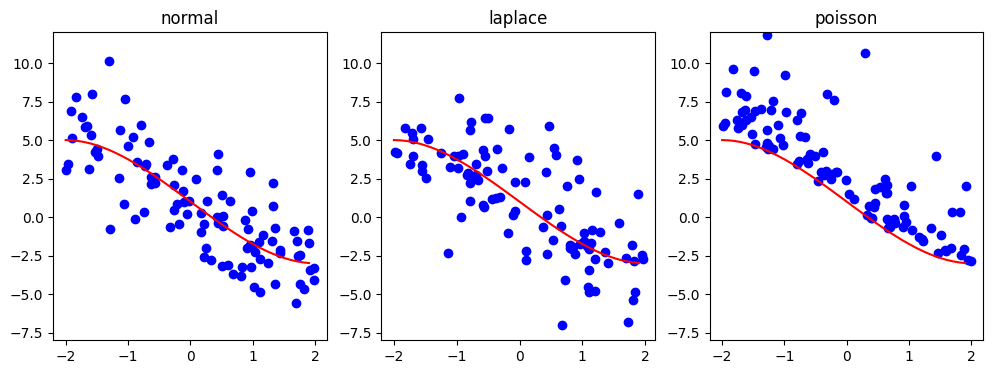

In [2]:
from scipy.stats import norm, laplace, expon

def f(x):
    return 0.25*x**3 - 3*x + 1

xx = np.arange(-2, 2, 0.1)
yy = f(xx)
N = 100

plt.figure(figsize=(12, 4))

for i, (rvs_func, name) in enumerate([
  (norm.rvs(loc=0, scale=1, size=N, random_state=None), 'normal'),
  (laplace.rvs(loc=0, size=N, random_state=None), 'laplace'),
  (expon.rvs(size=N, random_state=None), 'poisson'),
]):

    plt.subplot(1,3,i+1)
    plt.title(name)
    plt.ylim(-8,12)
    X = np.random.rand(N)*4 - 2
    Y = f(X) + 2*rvs_func

    plt.scatter(X, Y, color='blue')
    plt.plot(xx, yy, color='red')

На первом графике шум нормальный. Предсказание $y(x)$ соответствует условному матожиданию $\mathbb{E}(y|x)$ (а всё потому, что у нормального шума среднее равно нулю).

На втором графике шум из распределения Лапласа, и предсказание тоже равно условному матожиданию. У распределения Лапласа более тяжёлые хвосты, чем у нормального, поэтому такая модель позволяет точкам дальше отклоняться от среднего — то есть модель может лучше объяснять выбросы и не будет переобучаться под них.

Третий график несколько фантастичен. Тут шум из экспоненциального распределения. Напомним, что экспоненциальное распределение даёт неотрицательные значения, и наше предсказание соответствует не условному матожиданию, а условному минимуму. Конечно, придумать задачу, в которой такое актуально, не очень просто.

Такие модели на самом деле хорошо соответствуют инженерным. Если мы будем искать параметры $w$ с помощью метода максимального правдоподобия, то придём к минимизации лосса, равного минус логарифму правдоподобия. Логика "нужны более тяжёлые хвосты" совпадёт с логикой "модуль меньше штрафует выбросы, чем квадрат". Казалось бы, в чём разница? Как мы увидим дальше, вероятностная модель позволяет оценивать не только параметры, но и нашу уверенность в них.

Третий пример заставляет нас задуматься ещё кое о чём. Всё-таки условный минимум — это что-то странное. Может быть, можно как-то обойтись условным матожиданием? Предсказывать средним — это же хорошо?

Давайте рассмотрим чуть более сложную модель

$$y|x \sim p(y|x),\quad \mathbb{E}(y|x) = f_w(x)$$

Поясним, что тут написано, для случая экспоненциального распределения $p$. Если нам приносят $x$ и просят по нему сгенерировать таргет, то мы считаем $f_w(x)$, дальше ищем экспоненциальное распределение со средним $f_w(x)$. Матожидание экспоненциального распределения с параметром $\lambda$ равна $\frac1{\lambda}$, так что нам нужно распределение $\exp\left(\frac1{f_w(x)}\right)$. Из него мы и генерируем таргет. Давайте тоже посмотрим несколько примеров.

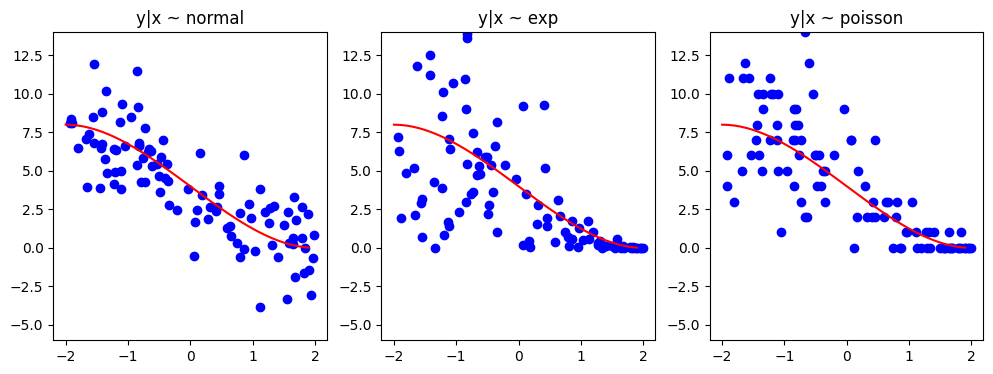

In [3]:
from scipy.stats import norm, expon, poisson

def f(x):
    return 0.25*x**3 - 3*x + 4

xx = np.arange(-2, 2, 0.1)
yy = f(xx)
N = 100
X = np.random.rand(N)*4 - 2

plt.figure(figsize=(12, 4))

for i, (Y, name) in enumerate([
    (norm.rvs(loc=f(X), scale=2, size=N), 'y|x ~ normal'),
    (expon.rvs(loc=0, scale=f(X), size=N), 'y|x ~ exp'),
    (poisson.rvs(mu=f(X), size=N), 'y|x ~ poisson'),
]):
    plt.subplot(1,3,i+1)
    plt.title(name)
    plt.ylim(-6,14)

    plt.scatter(X, Y, color='blue')
    plt.plot(xx, yy, color='red')

Пример с нормальным не поменялся, а вот средний, с экспоненциальным, стал другим. Обратите внимание, что вторая и третья модели кодируют ситуации, в которых (а) таргеты всегда неотрицательны и (б) дисперсия шума разная при разных значениях $f_w(x)$. Кроме того, у третьей все таргеты — целые числа. Итак, с помощью вероятностных моделей мы смогли описать вот такие разные и нетривиальные ситуации.

От этой разновидности моделей уже один шаг до GLM (обобщённых линейных моделей). На первый взгляд может показаться: давайте, мол, возьмём $f_w(x) = \langle x,w\rangle$ и будем радоваться жизни. Почему же так не делают?

Наивный ответ — потому что $\langle x, w\rangle$ может принимать не те значения. Скажем, если наша модель имеет вид $y|x \sim Bern(\theta)$ (распределение Бернулли), то условное матожидание всегда должно быть от $0$ до $1$. Поэтому полезно ввести дополнительную функцию $g$, для которой

$$\mathbb{E}(y|x) = g^{-1}(\langle x, w\rangle)$$

Например, сигмоиду.

Более правильный ответ содержит изрядное количество математики; почитать про обобщённые линейные модели вы можете в соответствующей главе учебника.

# Часть 1. Регрессия

## 1.1. Зачем нужны вероятностные модели

Если вы будете читать научные статьи по ML, вы будете часто сталкиваться с тем, что вместо привычных функций потерь пишут почему-то (минус) логарифм правдоподобия. Во многих случаях это действительно вопрос вкуса. Но порой в этом есть и содержательный смысл. И проявляется он, когда мы у нас возникают специфические вопросы к нашим моделям.

Начнём с того, что загрузим [данные](https://disk.yandex.ru/d/Jl-sbTB74cUgQA).

Данные содержат информацию о постах Илона Маска в Твиттере. В качестве обучающей выборке мы будем использовать период с марта 2019 по январь 2020, первую половину февраля 2020 возьмём в качестве валидационной выборки а вторую половину февраля 2020 в качестве тестовой выборки. Таргетом будет **число лайков, полученных постом**. Вам не надо будет парсить тексты; к вашим услугам много всяких фичей:

- длина твита;
- число упоминаний других пользователей Твиттера;
- количество ссылок в твите;
- месяц;
- день;
- час;
- день недели;
- фичи [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) числом 500 (extracted with sklearn.feature_extraction.text.TfidfVectorizer with stop_words="english"), можете пока просто считать, что это какие-то характеристики относительных частот разных слов в твитах.

Для измерения качества модели мы будем смотреть на метрики `RMSE` и `MAPE`.

In [4]:
data = pd.read_csv('./elon_tweets.csv', index_col=0)

Посты проиндексированы датой и временем. Чтобы с ними можно было удобно работать (например, упорядочивать), явно укажем, что это дата и время.

In [5]:
data.index = pd.to_datetime(data.index)

Теперь посмотрим на данные

In [6]:
data.head()

,id,n_mentions,n_urls,tweet_length,MONTH,DAY_OF_WEEK,DAY,HOUR,favorite_count,tfidf_000,...,tfidf_worldandscience,tfidf_worth,tfidf_wow,tfidf_wrong,tfidf_wsj,tfidf_yeah,tfidf_year,tfidf_years,tfidf_yes,tfidf_zero
created_at,,,,,,,,,,,,,,,,,,,,,
2019-03-16 20:05:14+00:00,1107009951266824192,2,0,191,3,5,16,20,7271,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:10:50+00:00,1107011362423599104,3,0,214,3,5,16,20,1401,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:38:07+00:00,1107018227727491073,3,0,312,3,5,16,20,1420,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:45:24+00:00,1107020062177714176,2,0,68,3,5,16,20,4001,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:53:52+00:00,1107022190426247168,3,0,153,3,5,16,20,742,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2883 entries, 2019-03-16 20:05:14+00:00 to 2020-03-10 05:53:48+00:00
Columns: 509 entries, id to tfidf_zero
dtypes: float64(500), int64(9)
memory usage: 11.2 MB


Предлагаем вам сделать one-hot encoding категориальных фичей 'MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR', убрав последние столбцы в каждой из групп (чтобы между столбцами не возникало линейной зависимости). Также добавьте столбцы из единиц (вы могли привыкнуть, что модели из `sklearn.linear_model` автоматически добавляют свободный член, но дальше вы столкнётесь с моделями, которые этого не делают).

Пожалуйста, назовите столбец из единиц 'intercept', а one-hot фичам дайте названия вида НАЗВАНИЕ_ФИЧИ + подчёркивание + значение фичи, например: 'MONTH_1', 'DAY_OF_WEEK_0', 'DAY_1', 'HOUR_0'.

In [8]:
def change_categoricals(the_data, list_of_cat_vars):
    # print(the_data.columns)
    for cat_var in list_of_cat_vars:
        df = pd.get_dummies(the_data[cat_var], prefix=cat_var)
        df = df.drop(df.columns[-1], axis=1)

        the_data = the_data.drop(cat_var, axis=1)
        the_data = pd.concat((the_data, df), axis=1)

    return the_data

list_of_cat_vars = ['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR']
data = change_categoricals(data, list_of_cat_vars)

Разделите данные на трейн, валидацию и тест. В валидационной выборке должны оказаться твиты, опубликованные между '2020-02-01' и '2020-02-14', а в тестовой - между '2020-02-15' и '2020-03-01'. Обратите внимание, что в ситуации, когда данные содержат временную компоненту, имеет смысл разбивать не случайным образом, а именно по времени. Это соответствует тому, как вы будете применять модель: она учится на данных из прошлого, а применяться будет в будущем.

In [9]:
data_train = data[data.index < '2020-02-01']
data_val = data[(data.index >= '2020-02-01') & (data.index < '2020-02-15')]
data_test = data[(data.index >= '2020-02-15') & (data.index < '2020-03-01')]

Не забудьте удалить таргет из всех датасетов.

Также давате разделим таргет на 100 (целочисленное деление)

In [11]:
y_train = data_train['favorite_count'].values.astype(int)//100
X_train = data_train.drop(['favorite_count', 'id'], axis=1)

y_val = data_val['favorite_count'].values.astype(int)//100
X_val = data_val.drop(['favorite_count', 'id'], axis=1)

y_test = data_test['favorite_count'].values.astype(int)//100
X_test = data_test.drop(['favorite_count', 'id'], axis=1)

In [12]:
X_train.columns

Index(['n_mentions', 'n_urls', 'tweet_length', 'tfidf_000', 'tfidf_10',
       'tfidf_100', 'tfidf_1000', 'tfidf_12', 'tfidf_13ericralph31',
       'tfidf_20',
       ...
       'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18',
       'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22'],
      dtype='object', length=573)

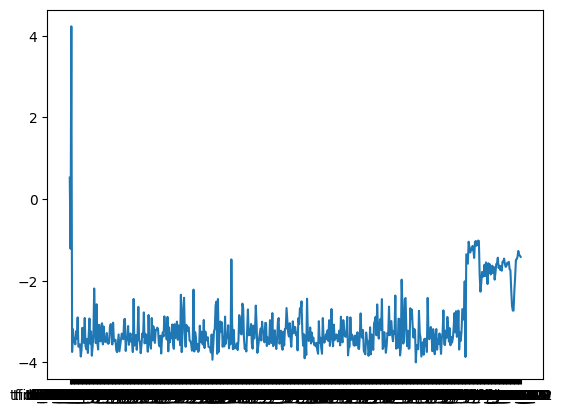

In [15]:
plt.plot(np.log(X_train.std(axis=0)))

In [16]:
X_train['intercept'] = [1]*X_train.shape[0]
X_val['intercept'] = [1]*X_val.shape[0]
X_test['intercept'] = [1]*X_test.shape[0]
X_train.shape

(2597, 574)

У вас должно было получиться 574 столбца.

Это был хороший момент, чтобы использовать `StandardScaler` или что-нибудь в этом роде, так как мы будем применять линейные модели. Но мы этот этап опустим и будем страдать.

Теперь хороший момент, чтобы изучить данные (и в первую очередь обучающие, чтобы не вносить информацию из теста). Рекомендуем хотя бы почитать названия признаков, а что точно будет важно — это то, каков таргет. Нарисуйте гистограмму для `y_train` с 20 бинами. Что вы можете сказать о поведении таргета?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>Возможно, сейчас вас посещают флешбеки с первой лабораторной: там таргет тоже в основном принимал маленькие значения, а с ростом их частота резко падала. К счастью, в этот раз у нас гораздо более интересные данные, так что и успехи у нас будут получше.</li>
    </ol>
</details>

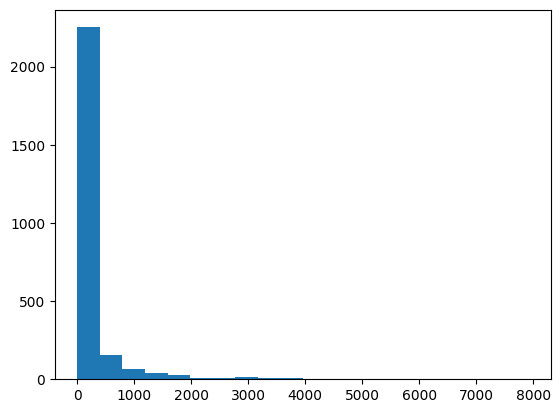

In [18]:
plt.hist(y_train, bins=20)
plt.show()

Выберем метрику для этой задачи. Вообще, мы будем использовать RMSE (корень из `mean_squared_error`), но мы могли бы взять и что-нибудь более изобретательное. Например, MAPE (`mean_absolute_percentage_error`). Как вам кажется, будет ли MAPE хорошим выбором в этой задаче? Если нет, то почему?


&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
Ответ на этот вопрос не так прост, как кажется. На первый взгляд, MAPE — вполне подходящая метрика. И для тех моделей, которые мы будем строить, она будет вести себя разумным образом: падать с увеличением их адекватности. Но вот одна проблема: модель, которая выдаёт всегда нулевое предсказание, будет по этой метрике лучше наших самых крутых моделей.
</details>

Постройте обычную линейную регрессию (без регуляризации). Обычно говорят, что коэффициенты регрессии хорошо интерпретируемы:

- положительный коэффициент означает, что с ростом данного признака таргет растёт;
- скорость роста или убывания определяется абсолютным значением коэффициента.

Как у полученной модели с интерпретируемостью?

In [22]:
# <YOUR CODE HERE>
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
lr.coef_[:10]

array([-8.57786723e+01, -4.53138051e+02, -2.17776339e-01, -1.15100183e+00,
       -1.25455248e+02, -1.34178231e+02, -3.70008640e+00,  3.76545310e+01,
        7.54158566e+02, -7.90258167e+01])

Признаков многовато, чтобы в них разобраться, но это не самая большая проблема. Сгенерируйте 10 различных подвыборок обучающей выборки длины 2000, обучите на них регрессию и распечатайте для каждой значения коэффициента при признаке 'tweet_length'. Поразитесь разнообразию.

*Disclaimer*: если бы мы генерировали семплы из обучающей выборки *с возвращением* того же размера, что и сама обучающая выборка, то мы бы получили честную оценку распределения этого коэффициента с помощью бутстрепа.

In [31]:
# <YOUR CODE HERE>
for _ in range(10):
    sample_indices = np.random.choice(np.arange(X_train.shape[0]),  X_train.shape[0])
    sample = X_train.iloc[sample_indices]
    lr = LinearRegression().fit(sample, y_train)
    print(lr.coef_[2])

-0.37344921605286174
-0.6794052862846236
-0.2350389537820874
-0.02512301498071423
0.324067587066736
1.050541692590798
0.8212424846710604
-0.33662150618795295
-0.37005312642418176
0.2754537901014942


In [41]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

print(mean_squared_error(y_test, lr.predict(X_test)))
print(root_mean_squared_error(y_test, lr.predict(X_test)))

584309.666728943
764.401508847898


Итак, мы поняли, что не очень-то можем доверять полученному значению этого коэффициента (а на самом деле и не только этого). Возникает два вопроса:

- как померить нашу уверенность в том или ином коэффициенте?
- что делать, если коэффициент нестабилен и может даже менять знак при смене выборки и как найти "хорошие" признаки?

На эти вопросы мы в дальнейшем попытаемся в той или иной мере ответить.

## 1.2. Прежде чем мы начали: отбор с помощью L1-регуляризации

Если речь про отбор информативных признаков в линейной модели, то не стоит забывать про старую добрую L1-регуляризацию, которая разреживает признаки в том смысле, что часть выученных весов может занулиться.

**1. L1-регуляризация.**  Что надо сдать в контест? Обучите L1-регуляризованную линейную регрессию (`Lasso()`). Подберите по кросс-валидации коэффициент регуляризации по логарифмической сетке (семь степеней 10 от `1e-3` до `1e+3`; воспользуйтесь `np.logspace` для задания списка возможных значений); убедитесь, что сравнение идёт по метрике `MSE` (если что, за это отвечает параметр `scoring`). Лучшую из моделей обучите на всей обучающей выборке и выясните, какие из фичей получили веса, по модулю превосходящие `1е-10`. **Отправьте в контест список этих фичей**.

Кстати, а вы понимаете, почему по кросс-валидацию подбирать параметры в данном случае не совсем корректно?

&nbsp;

<details>
  <summary>Кликните сюда, чтобы узнать ответ</summary>
    <ol>
      <li>Собственно, потому же, почему мы делили на train/val/split не случайно, а по времени. Сделав кросс-валидацию, мы как минимум в каких-то фолдах будем предсказывать прошлое по будущему, что максимально странно, конечно. Кросс-валидацию в этой ситуации сделать тоже можно, но по-другому. Подробнее об этом читайте в учебнике в главе про кросс-валидацию, а тут из соображений простоты мы использовали обычную.</li>
    </ol>
</details>

Посчитайте значение `RMSE` на тесте для самого лучшего классификатора. Стало ли лучше по сравнению с исходным? (спойлер: стало)

Какие из немногочисленных отобранных фичей влияют на предсказание в положительную сторону, а какие в отрицательную? Логично ли это?

In [88]:
# <YOUR CODE HERE
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

parameters = {'alpha': np.logspace(-3, 3, base=10)}
lasso = Lasso(max_iter=10000)
clf = GridSearchCV(lasso, parameters, scoring=make_scorer(mean_squared_error, greater_is_better=False))
clf.fit(X_train, y_train)

GridSearchCV(estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.599858...
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

In [89]:
clf.best_params_

{'alpha': 3.5564803062231287}

In [166]:
best_lasso = Lasso(max_iter=9000, alpha=3.5).fit(X_train, y_train)
print(root_mean_squared_error(y_test, best_lasso.predict(X_test)))

selected_columns = np.where(np.abs(best_lasso.coef_) > 10**-10)[0]
X_test_selected = X_test.iloc[:, selected_columns]
print(np.array(X_test_selected.columns.values).size, sep=",")
print(*X_test_selected.columns.values, sep=",")

478.97923260744784
16
n_mentions,n_urls,tweet_length,tfidf_cybertruck,tfidf_https,MONTH_1,MONTH_4,MONTH_6,MONTH_8,MONTH_9,MONTH_10,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_3,DAY_23,HOUR_6


In [168]:
best_lasso_selected =  Lasso(max_iter=9000, alpha=3.5).fit(X_train.iloc[:, selected_columns], y_train)
print(root_mean_squared_error(y_test, best_lasso_selected.predict(X_test.iloc[:, selected_columns])))

478.97924454615014


## 1.3. В дело вступают вероятностные модели

Вспомним, что модель линейной регрессии с функцией потерь MSE эквивалентна следующей вероятностной модели:

$$y = \langle x, w\rangle + \varepsilon,\ \varepsilon\sim\mathcal{N}(0, \sigma^2),$$

где не очень важно, чему равна дисперсия $\sigma^2$.

Может оказаться, что в линейной модели некоторые признаки более полезны, чем другие. Например, вы можете столкнуться с ситуацией, когда один из коэффициентов в выученном векторе весов $w$ очень мал по сравнению с остальными. Или же случится, как в нашей задаче. А именно, вспомним, что в модели линейной регрессии, которую мы выучили по всем фичам, как минимум один из коэффициентов (при фиче `tweet length`) какой-то сомнительный: при обучении на разных подвыборках он получается не то что разным по величине, а даже разным по знаку. Это заставляет нас усомниться в том, что данная фича информативная. Но как проверить информативность? Оказывается, вероятностная модель предоставляет для этого определённые инструменты.

Допустим, мы подозреваем, что коэффициент $w_1$ не информативен. Это значит, что, хотя исходная модель имела вид

$$y = w_1x_1 + \sum_{i=2}^Dw_ix_i + \varepsilon,\ \varepsilon\sim\mathcal{N}(0, \sigma^2),$$

мы считаем более правильной "обрезанную" модель

$$y = \sum_{i=2}^Dw_ix_i + \varepsilon,\ \varepsilon\sim\mathcal{N}(0, \sigma^2).$$

Оформим наше предположение в виде статистической гипотезы.

- $H_0$: $w_1 = 0$;
- $H_1$: $w_1 \ne 0$.

Если гипотеза $H_0$ отклоняется, то это значит, что есть статистические аргументы в пользу того, что $w_1$ значим. Если же гипотезу не получается отклонить, то коэффициент $w_1$ может быть не значим.

К счастью, статистика умеет проверять такие гипотезы, а в Python есть библиотека statsmodels, в которой их проверка реализована. Давайте же заимпортим её как можно скорей!

&nbsp;

<details>
  <summary>Немного математики, которую можно пропустить, но которая, возможно, поможет вам понять и простить эти странные гипотезы (клик)</summary>

Давайте очень неформально разберёмся с тем, как проверять гипотезу $H_0$.
    
Пусть $\widehat{w} = (X^TX)^{-1}X^Ty$ — оценка вектора весов. Как она распределена? Напоним, что вектор $y$ равен $Xw + \varepsilon$, где $Xw$ константа, а $\varepsilon\sim\mathcal{N}(0,\sigma^2)$, так что
    
$$y\sim\mathcal{N}(Xw, \sigma^2)$$
    
В свою очередь,
    
$$\widehat{w} = (X^TX)^{-1}X^Ty = \underbrace{(X^TX)^{-1}X^TXw}_{=w} + (X^TX)^{-1}X^T\varepsilon.$$
    
Константа плюс константа, умноженная на нормальное, имеет нормальное распределение. Матожидание второго слагаемого равно нулю, так что $$\mathbb{E}\widehat{w} = w$$ (приятно!). В то же время первое, постоянное слагаемое, не влияет на ковариацию, и
    
$$Cov(\widehat{w}) = (X^TX)^{-1}X^T\cdot \underbrace{Cov(\varepsilon)}_{=\sigma^2I}\cdot ((X^TX)^{-1}X^T)^T = \sigma^2(X^TX)^{-1}$$
    
Это неплохо, но $\sigma^2$ мы не знаем, и его тоже приходится оценивать. Воспользуемся несмещённой оценкой дисперсии:
    
$$\widehat{\sigma^2} = \frac1{N - D}\vert y - X\widehat{w}\vert^2$$

Теперь обратимся к одному оцененному коэффициенту $\widehat{w}_i$. Он распределён нормально. Его матожидание равно $w_i$, оценка его дисперсии имеет вид $\widehat{\sigma}^2\cdot[(X^TX)^{-1}]_{ii}$. Можно показать, что дробь
    
$$\frac{\widehat{w}_i - w_i}{\widehat{\sigma}\sqrt{\cdot[(X^TX)^{-1}]_{ii}}}$$
    
имеет распределение Стьюдента $t_{N-D}$ с $N - D$ степенями свободы. Это позволяет нам написать доверительный интервал для $w_i$. А именно, если $y_{1-\frac{\alpha}2}$ — квантиль $t_{N-D}$ уровня $1 - \frac{\alpha}2$, то доверительный интервал с уровнем доверия $1 - \alpha$ имеет вид
    
$$\widehat{w}_i - y_{1-\frac{\alpha}2}\widehat{\sigma}\sqrt{[(X^TX)^{-1}]_{ii}}\leqslant\widehat{w}_i + y_{1-\frac{\alpha}2}\widehat{\sigma}\sqrt{[(X^TX)^{-1}]_{ii}}$$
    
Выпишем критерий для проверки $H_0$. Одно его обличье — это "доверительный интервал содержит ноль". Другое: если $H_0$ верна, то
    
$$T = \frac{\widehat{w}_i}{\widehat{\sigma}\sqrt{\cdot[(X^TX)^{-1}]_{ii}}}\sim t_{N-D}$$
    
Теперь мы считаем p-value: вероятность того, что величина с распределением $t_{N-D}$ по модулю превосходит наблюдаемое значение статистики $T$. Если p-value < $\alpha$, то мы отклоняем гипотезу на уровне значимости $1 - \alpha$: значение статистики слишком необычно, чтобы мы поверили, что $T\sim t_{N-D}$.

    
</details>

Небольшая иллюстрация математики. Посмотрим снова на переменную `tweet_length`. Напишем для неё статистику $T$. Нам придётся добавить небольшую регуляризацию, чтобы матрица стала невырожденной (слагаемое `1e-14*np.eye(X_train.shape[1])`).

In [101]:
index = 2 # index of the 'tweet_length' feature

X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)

M = np.linalg.inv(X_train.T.dot(X_train) + 1e-14*np.eye(X_train.shape[1]))
w_pred = M.dot(X_train.T).dot(y_train)

T = (w_pred[index]) / (
    np.sqrt(np.sum( (X_train.dot(w_pred) - y_train) ** 2) * M[index][index] /
    (X_train.shape[0] - X_train.shape[1]))
)

print('T statistic =', T)

T statistic = -0.5892540733630108


Нарисуем значение статистики рядом с графиком плотности распределения Стьюдента.

Распределение Стьюдента реализовано тут: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html

Как и у всякого распределения из scipy, у него есть несколько методов:

- rvs (позволяет генерировать наборы случайных чисел из этого распределения);
- pdf (функция плотности);
- cdf (функция распределения);
- ppf (квантили).

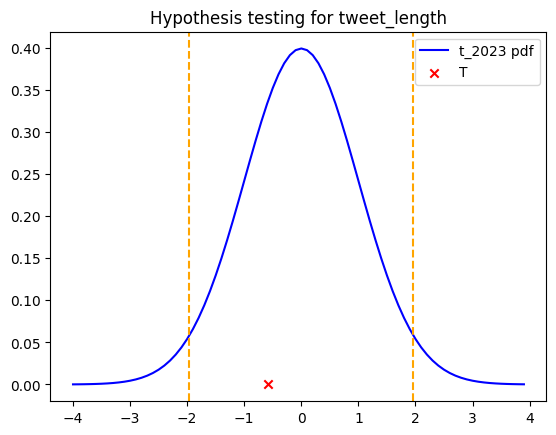

In [102]:
from scipy import stats

xx = np.arange(-4, 4, 0.1)
df = X_train.shape[0] - X_train.shape[1] # t distribution parameter

plt.title('Hypothesis testing for tweet_length')
plt.plot(xx, stats.t.pdf(xx, df),
         label='t_%d pdf'%(df), color='blue')
plt.scatter([T], [0], marker='x', color='red', label='T')
plt.axvline(x=stats.t.ppf(0.05/2, df),
           linestyle='--', color='orange')
plt.axvline(x=stats.t.ppf(1-0.05/2, df),
           linestyle='--', color='orange')
plt.legend()

Рыжие пунктирные прямые — это квантили уровня $\frac{\alpha}2$ и $1 - \frac{\alpha}{2}$ нашего распределения. Если бы красный крестик не попал между ними, мы бы сказали, что статистика принимает слишком необычное значение, и отвергли бы гипотезу $H_0$. Это значило бы, что коэффициент при `tweet_length` статистически значим. Но в нашем случае это не так. Значение статистики вполне обыденно. То есть мы не можем отвергнуть гипотезу о том, что коэффициент при `tweet_length` бесполезен.

Для приличия посчитаем p_value. Если оно больше $0.05$, то гипотеза не отклоняется.

In [103]:
p_value = stats.t.cdf(-np.abs(T), df) + (1 - stats.t.cdf(np.abs(T), df))
print(p_value)

0.5557566431804006


**А теперь давайте же наконец узнаем, как библиотека statsmodels помогает определять статзначимость!**

In [104]:
import statsmodels.api as sm

Синтаксис этой библиотеки отличается от привычного sklearn-подобного. Так, если мы хотим вызвать модель `OLS` (обычную линейную регрессию), то это делается следующим образом:

In [105]:
sm_ols = sm.OLS(y_train, X_train).fit()

Обратите внимание: в `statsmodels` модели не вводят за вас константное слагаемое! Вам надо не забывать самостоятельно добавлять столбец из единиц.

Очень важный инструмент - это метод summary. Он позволяет очень много всего узнать о выученной модели. Давайте же посмотрим на него внимательнее:

In [106]:
sm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     2.328
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           5.96e-42
Time:                        19:03:17   Log-Likelihood:                -19690.
No. Observations:                2597   AIC:                         4.052e+04
Df Residuals:                    2026   BIC:                         4.387e+04
Df Model:                         570                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
n_mentions              -85.7787     12.641     -6.786      0.000    -110.570     -60.987
n_urls                 -453.1381     50.454     -8.981      0.000    -552.086    -354.190
tweet_length             -0.2178      0.369     -0.590      0.555      -0.942       0.506
tfidf_000                -1.1330    547.486     -0.002      0.998   -1074.828    1072.562
tfidf_10               -125.4558    294.143     -0.427      0.670    -702.310     451.398
tfidf_100              -134.1533    420.953     -0.319      0.750    -959.700     691.394
tfidf_1000               -3.6906    390.483     -0.009      0.992    -769.481     762.100
tfidf_12                 37.6520    480.986      0.078      0.938    -905.627     980.932
tfidf_13ericralph31     754.1754    384.797      1.960      0.050      -0.464    1508.815
tfidf_20                -79.0320    364.402     -0.217      0.828    -793.674     635.610
tfidf_28delayslater      49.0373    216.849      0.226      0.821    -376.232     474.307
tfidf_30               -718.2099    471.661     -1.523      0.128   -1643.200     206.781
tfidf_46txqrrsdr         34.0464    521.198      0.065      0.948    -988.093    1056.186
tfidf_60                -88.9157    465.816     -0.191      0.849   -1002.444     824.613
tfidf__mikemo           -17.5159    308.176     -0.057      0.955    -621.890     586.858
tfidf_able             -152.2430    480.568     -0.317      0.751   -1094.701     790.215
tfidf_absolutely        -37.7684    265.013     -0.143      0.887    -557.495     481.958
tfidf_access           -325.6724    493.339     -0.660      0.509   -1293.176     641.831
tfidf_actual           -281.5103    404.239     -0.696      0.486   -1074.277     511.257
tfidf_actually          823.8171    216.561      3.804      0.000     399.111    1248.523
tfidf_add                56.5592    432.798      0.131      0.896    -792.215     905.334
tfidf_adding            536.7193    500.883      1.072      0.284    -445.581    1519.020
tfidf_advanced            2.3352    350.223      0.007      0.995    -684.500     689.171
tfidf_aerojetrdyne     -181.8897   1165.018     -0.156      0.876   -2466.649    2102.869
tfidf_ago               363.3604    354.998      1.024      0.306    -332.839    1059.560
tfidf_agreed             -3.5723    212.865     -0.017      0.987    -421.030     413.885
tfidf_aiming           -134.5891    416.586     -0.323      0.747    -951.571     682.393
tfidf_air               -64.2583    309.324     -0.208      0.835    -670.885     542.368
tfidf_aircraft          111.3105    600.605      0.185      0.853   -1066.557    1289.179
tfidf_allow             227.2064    442.960      0.513      0.608    -641.498    1095.910
tfidf_amazing          -317.5664    334.413     -0.950      0.342    -973.395     338.263
tfidf_amp              

Первая таблица содержит разные метрики, в частности, [коэффициент $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) ("доля объяснённой дисперсии"), который во многом похож на MSE, но очень любим в эконометрике. Но особенно важна для нас сейчас вторая таблица, с информацией про каждый из коэффициентов:

- `coef` - это сам коэффициент;
- `std err` - это стандартная ошибка оценки коэффициента (см. se оценки в учебнике);
- `t` - это значение статистики, с помощью которой проверяют гипотезу $H_0: \widehat{w}_i = 0$, а `P>|t|` - соответствующее p-value, то есть вероятность, с которой значение статистики может быть "более необычным", чем $t$, при условии выполнения гипотезы $H_0$. Вам нужно понимать следующее: если `P>|t|` меньше $0.05$, то гипотеза $H_0$ отвергается на уровне значимости $0.05$ (то есть коэффициент $\widehat{w}_i$ информативен и значим). Ну, а чем больше p-value, тем спокойнее мы можем себя чувствовать, пренебрегая соответствующим признаком.
- `[0.025, 0.975]` - это доверительный интервал для $\widehat{w}_i$ с уровнем значимости $0.95$, то есть такой промежуток, в котором (если наша модель верна) с вероятностью $0.95$ находится истинное значение коэффициента $w_i$. Есть очень простая связь с предыдущим пунктом: если доверительный интервал содержит ноль, то коэффициент не значим.

**2.** Обратите внимание, что почти у все коэффициенты оказались не значимы. Давайте выкинем все признаки, для которых `P>|t|` превосходит $0.05$. Загрузите в контест список оставшихся признаков.

Постройте на них линейную модель, найдите `RMSE` и `MAPE`. Сравните с исходной моделью и с L1-регуляризованной (спойлер: она лучше, чем исходная, но немного похуже L1-регуляризованной).

Подумайте над физическим смыслом отобранных признаков и соответствующих коэффициентов. Кажутся ли вам логичными их знаки?

In [142]:
features = (sm_ols.pvalues.index.to_numpy())
mask = ([sm_ols.pvalues<0.05][0]).to_numpy()
print(features[mask].size)
print(*features[mask], sep=",")

34
n_mentions,n_urls,tfidf_actually,tfidf_area,tfidf_art,tfidf_color,tfidf_complete,tfidf_cybertruck,tfidf_day,tfidf_free,tfidf_game,tfidf_going,tfidf_happy,tfidf_home,tfidf_https,tfidf_insane,tfidf_life,tfidf_long,tfidf_oxygen,tfidf_simulation,tfidf_sounds,tfidf_travel,tfidf_video,tfidf_yes,MONTH_3,MONTH_4,MONTH_6,MONTH_7,MONTH_9,DAY_17,DAY_23,HOUR_1,HOUR_22,intercept


## 1.4. Умный отбор признаков

То, что нам не удалось превзойти L1-регуляризованную модель, наталкивает на мысль о том, что просто так выкидывать все признаки, которые нам показались не значимыми, возможно, не очень здорово. А как вам кажется, почему?


&nbsp;

<details>
  <summary>Кликните сюда, чтобы узнать ответ</summary>

Из-за того, что признаков слишком много, информация о таргете "размазывается" по ним, и каждый кажется не важным, хотя вместе они что-то дают полезное. Иными словами, часть признаков оказывается приближённо линейно зависимой. В эконометрической литературе такая ситуация называется термином *мультиколлинеарность*.

</details>

Итак, нам надо придумать более грамотный способ отбора признаков. Различных стратегий много, мы познакомимся с самой базовой. Она заключается в следующем. Допустим, у нас есть некоторый внешний критерий отбора моделей (не лосс на трейне!). Тогда действуем следующим образом:

```
отобранные признаки = [] (константное предсказание);
while внешний критерий достаточно существенно улучшается:
    для каждого ещё не добавленного признака:
        обучаем модель на отобранных признаках + текущем
    выбираем наилучшую по внешнему критерию модель среди рассмотренных
    добавляем соответствующий признак к отобранным
```

Критерии могут быть разными. В принципе, можно использовать метрику на валидационной выборке. Но вам может захотеться сделать отбор исключительно на обучающей выборке. Для этого вам нужны сильные и умные способы оценки обобщающей способности модели. Для сложных моделей (скажем, нейросетей) особо ничего пока не придумали, а вот для линейных моделей можно применить `AIC` (информационный критерий Акаике), благо он считается в `statsmodels` (он в верхней табличке в `summary`) и для обученного классификатора `sm_clf` может быть вызван с помощью`sm_clf.aic`.

Критерий Акаике был получен из вполне красивых теоретических соображений оценки истинного риска (матожидания логарифма правдоподобия на всей вселенной данных) с помощью эмпирического (среднего значения логарифма правдоподобия на объектах выборки). Вывод можно найти [вот тут](https://faculty.washington.edu/yenchic/19A_stat535/Lec7_model.pdf), а мы просто скажем, что

$$\text{AIC} = 2D - 2\ell(X, y, w),$$

где $D$ - число признаков, а $\ell$ - логарифм правдоподобия. Иными словами, `AIC` будет меньше для более простых моделей и для более точных, с более высоким логарифмом правдоподобия.

&nbsp;

**3.** Отберите параметры в модели `sm.OLS` с помощью `AIC` и сдайте список в контест именно в том порядке, в котором вы их получили. Стартуйте с модели с единственным признаком **intercept**. Важно: остановитесь на 40 первых признаках (включая intercept).

In [247]:
# <YOUR CODE HERE>
selected_features = ["intercept"]
sm_ols = sm.OLS(y_train, X_train[selected_features]).fit()
aic = 100000
while sm_ols.aic <= aic and len(selected_features) < 40:
    #print(aic, selected_features)
    feature = ""
    for feature_ in X_train.columns.values:
        if feature_ not in selected_features:
            sm_ols_ = sm.OLS(y_train, X_train[selected_features + [feature_]]).fit()
            aic_ = sm_ols_.aic
            #print(feature_, int(aic_), int(aic), aic_<aic, selected_features)
            if aic_ < aic:
                sm_ols = sm_ols_
                feature = feature_
                aic = aic_
    selected_features.append(feature)
print(*selected_features, sep=",")

intercept,tfidf_https,n_mentions,n_urls,tfidf_cybertruck,tfidf_art,tfidf_insane,tfidf_game,tfidf_happy,tfidf_life,tfidf_actually,tfidf_free,tfidf_simulation,tfidf_orion_sword,tfidf_travel,tfidf_going,tfidf_oxygen,tfidf_area,MONTH_1,tfidf_color,tfidf_space,tfidf_complete,tfidf_video,tfidf_home,tfidf_light,tfidf_haha,tfidf_day,tfidf_shanghai,tfidf_mkbhd,tfidf_single,tfidf_twitter,MONTH_10,tfidf_way,tfidf_just,tfidf_13ericralph31,tweet_length,tfidf_nichegamer,tfidf_yes,tfidf_speed,tfidf_don


In [248]:
root_mean_squared_error(y_test, sm_ols.predict(X_test.loc[:, selected_features]))

495.01885902361494

Распечатайте `RMSE` полученной модели. Стала ли модель лучше, чем исходная? А чем L1-регуляризованная?

Все ли признаки в полученной модели оказались значимы? Нетрудно убедиться, что нет, и вы могли бы в какой-то момент остановиться, когда несколько признаков подряд оказались не значимы. Рекомендуем проверить успешность AIC с помощью `RMSE` на тесте. Можно убедиться, если если бы мы не довели до 40 признаков, а остановились (сильно) раньше, то мы побили бы по качеству L1-регуляризованную регрессию, пусть и не сильно.

**Замечание, из которого вы узнаете, что мы не очень правильно применили критерий AIC**

&nbsp;

<details>
  <summary>Кликните сюда, чтобы прочитать его</summary>
    
Давайте распишем подробнее, какой вид имеет AIC для модели линейной регрессии $y = \langle x, w\rangle + \varepsilon$ $\varepsilon\sim\mathcal{N}(0, \sigma^2)$. Логарифм правдоподобия в этой модели равен
    
$$\log{p(y\mid X, w)} = -\frac{N}2\log(2\pi\sigma^2) - \frac1{2\sigma^2}\sum_{i=1}^N(y_i - \langle x_i, w\rangle)^2$$
    
Значение $\frac1{2\sigma^2}$ не влияет на поиск точки минимума, но для того, чтобы посчитать AIC, его знать нужно. Что делать? Его тоже можно отыскать с помощью метода максимального правдоподобия:
    
$$\widehat{\sigma}^2 = \frac{1}{N} \sum_{i=1}^N (y_i - \langle x_i, w\rangle)^2$$
    
Вообще говоря, эта оценка является смещённой. Несмещённая имеет вид
    
$$\widehat{\sigma}^2_{unbiased} = \frac{1}{N - D} \sum_{i=1}^N (y_i - \langle x_i, w\rangle)^2,$$
    
где $D$ — число признаков. Но это не самое страшное. Интересные вещи начинаются, когда мы хотим сравнить две модели с разными наборами признаков. Вообще говоря, по каждому из них мы можем построить свою оценку $\widehat{\sigma}^2$, и библиотека statsmodels так и делает (собственно, откуда ей знать, что есть какие-то ещё наборы признаков). Но так делать неправильно, потому что это может привести к ошибкам. Можете думать об этом так, что, каждый раз заново оценивая дисперсию, вы вносите дополнительную степень свободы вдобавок к варьированию признаков, что делает сравнение некорректным. Правильным будет использовать для всех наборов признаков одну и ту же оценку $\widehat{\sigma}^2$, вычисленную на полном наборе признаков.

</details>

## 1.5. А выполнены ли предположения?

Напомним, что линейная регрессия соответствовала у нас вполне конкретной вероятностной модели

$$y = \langle x, w\rangle + \varepsilon,\quad\varepsilon\sim\mathcal{N}(0,\sigma^2)$$

В этом предположении содержится идея о том, что шум в модели не коррелирует с признаками. Но так ли это? Нарисуйте скаттерплот, в котором по оси х значения признака `n_mentions`, а по оси у квадраты отклонения предсказаний модели на соответствующем объекте и истинного таргета. Похоже ли, что эти две вещи не коррелируют?

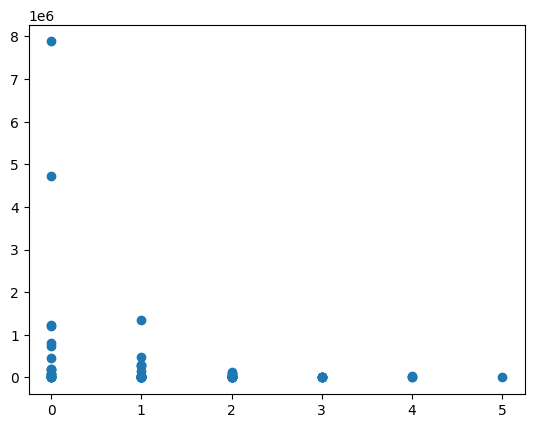

In [249]:
# <YOUR CODE HERE>
plt.scatter(X_test["n_mentions"], (sm_ols.predict(X_test.loc[:, selected_features]) - y_test) ** 2)

Не очень. В эконометрике ситуацию, когда остатки коррелируют с фичами, называют умным словом **гетероскедастичность**. Но в эконометрике учат ещё и не верить графикам. Как вам кажется, почему из построенного вами графика нельзя однозначно делать вывод о гетероскедастичности?

&nbsp;

<details>
  <summary>Кликните сюда, чтобы узнать ответ</summary>
    <ol>
      <li>Это всё-таки зависимость остатков от одного-единственного признака из 40. Зависимость вполне может быть объяснена значениями других признаков.</li>
    </ol>
</details>

Для проверки разных оттенков гетероскедастичности есть разные статтесты, их можно найти тут: https://www.statsmodels.org/stable/diagnostic.html. Одним из таких тестов является тест Бройша-Пагана. Грубо говоря, в нём строится регрессия стандартизованных остатков на фичи исходной модели и считается статзначимость коэффициентов этой регрессии.

In [250]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

test = het_breuschpagan(sm_ols.resid, sm_ols.model.exog)
lzip(names, test)

[('Lagrange multiplier statistic', 297.30491036600625),
 ('p-value', 1.740345253389637e-41),
 ('f-value', 8.476136564326222),
 ('f p-value', 1.6701493079119192e-44)]

В качестве нулевой выступает гипотеза о том, что всё хорошо. Все p-value маленькие, так что нулевая гипотеза отвергается. Значит, гетероскедастичность имеет место.

Выходит, мы действовали в неверных предположениях. Обнаружив подобное, вы можете сделать одну из двух вещей:

- поменять модель (это мы сделаем дальше);
- преобразовать таргет (скажем, логарифмировать; возможно, вы уже давно спрашиваете себя, почему мы этого до сих пор не сделали);
- не менять модель (в конце концов, она как-то решала задачу предсказания), но пересмотреть оценки статзначимости коэффициентов. Ведь при получении прежних оценок мы существенно опирались на то, какие у нас распределения.

Давайте пока поисследуем второй путь. В рассуждении, которое мы использовали при построении доверительного интервала для $\widehat{w}_i$, сломается этап вычисления ковариации:

$$Cov(\widehat{w}) = (X^TX)^{-1}X^T\cdot \underbrace{Cov(\varepsilon)}_{\color{red}{\ne\sigma^2I}}\cdot ((X^TX)^{-1}X^T)^T$$

Для заклейки этой дыры придумали много ~~подорожников~~ разных способов. Воззвать к ним можно с помощью параметра `cov_type` функции `fit`. Давайте воспользуемся [робастной оценкой HC3](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.HC3_se.html#statsmodels.regression.linear_model.RegressionResults.HC3_se).

In [251]:
# predictors - это фичи, отобранные с помощью AIC на предыдущем шаге

sm_ols_robust = sm.OLS(y_train, X_train[selected_features]).fit(cov_type='HC3')
sm_ols_ = sm.OLS(y_train, X_train[selected_features]).fit()

In [252]:
sm_ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     9.183
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           3.24e-49
Time:                        21:10:15   Log-Likelihood:                -19828.
No. Observations:                2597   AIC:                         3.974e+04
Df Residuals:                    2557   BIC:                         3.997e+04
Df Model:                          39                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept             251.3508     20.403     12.319      0.000     211.361     291.341
tfidf_https          1141.0482    125.674      9.079      0.000     894.732    1387.364
n_mentions            -74.3035      6.776    -10.965      0.000     -87.585     -61.022
n_urls               -419.2499     59.014     -7.104      0.000    -534.916    -303.584
tfidf_cybertruck     1807.5471    740.987      2.439      0.015     355.239    3259.855
tfidf_art            1287.6359    891.963      1.444      0.149    -460.580    3035.852
tfidf_insane         1926.4981   1604.941      1.200      0.230   -1219.129    5072.125
tfidf_game           1304.2743   1397.336      0.933      0.351   -1434.454    4043.003
tfidf_happy          1040.8351    654.005      1.591      0.112    -240.990    2322.661
tfidf_life           1171.4333   1219.116      0.961      0.337   -1217.990    3560.857
tfidf_actually        687.4053    431.367      1.594      0.111    -158.058    1532.869
tfidf_free            972.5646   1424.014      0.683      0.495   -1818.451    3763.581
tfidf_simulation     1080.4013    703.428      1.536      0.125    -298.292    2459.094
tfidf_orion_sword     772.7243    226.795      3.407      0.001     328.214    1217.234
tfidf_travel         1306.2679    407.168      3.208      0.001     508.233    2104.303
tfidf_going           792.0694    431.833      1.834      0.067     -54.307    1638.446
tfidf_oxygen         1010.3250   1292.839      0.781      0.435   -1523.593    3544.243
tfidf_area            884.4237    750.233      1.179      0.238    -586.006    2354.853
MONTH_1               102.2582     47.195      2.167      0.030       9.758     194.758
tfidf_color           723.7820    969.868      0.746      0.456   -1177.125    2624.689
tfidf_space           490.5872    232.158      2.113      0.035      35.567     945.608
tfidf_complete        719.0307    899.395      0.799      0.424   -1043.751    2481.812
tfidf_video           663.3514    794.931      0.834      0.404    -894.685    2221.388
tfidf_home            636.3896    252.622      2.519      0.012     141.260    1131.519
tfidf_light           602.8944    385.891      1.562      0.118    -153.438    1359.226
tfidf_haha            234.4289    175.696      1.334      0.182    -109.929     578.787
tfidf_day             540.0451    744.670      0.725      0.468    -919.480    1999.571
tfidf_shanghai        936.0078   1469.014      0.637      0.524   -1943.208    3815.223
tfidf_mkbhd           442.7492    568.300      0.779      0.436    -671.099    1556.597
tfidf_single          936.1610   1068.150      0.876      0.381   -1157.374    3029.696
tfidf_twitter         540.7510    637.495      0.848      0.396    -708.716    1790.218
MONTH_10               66.2133     35.357      1.873      0.061      -3.084     135.511
tfi

In [253]:
common_important = sm_ols_.pvalues[sm_ols_.pvalues < 0.05]
robust_non_important = sm_ols_robust.pvalues[sm_ols_robust.pvalues > 0.05]
for f in robust_non_important.index:
    if f in list(common_important.index):
        print(f, end=",")

tfidf_art,tfidf_insane,tfidf_game,tfidf_happy,tfidf_life,tfidf_actually,tfidf_free,tfidf_simulation,tfidf_going,tfidf_oxygen,tfidf_area,tfidf_color,tfidf_complete,tfidf_video,tfidf_light,tfidf_haha,tfidf_day,tfidf_shanghai,tfidf_single,tfidf_way,

**4.** Возьмите признаки, которые вы отобрали с помощью AIC, и обучите на них просто OLS и OLS с `cov_type='HC3'`. Сдайте в контест названия фичей, которые обычный OLS объявил значимыми на уровне 0.95, а робастный — нет.

Обучите `OLS` на 10 случайных подвыборках обучающей выборки длины 2000. Для каждой выведите коэффициент при `tfidf_free`. Убедитесь, что попадаются коэффициенты разных знаков. И это при том, что обычный OLS признал его значимым!

In [254]:
for _ in range(10):
    sample_indices = np.random.choice(np.arange(X_train.shape[0]),  X_train.shape[0])
    sample = X_train.iloc[sample_indices]
    sm_ols_s = sm.OLS(y_train, sample).fit(cov_type='HC3')
    print(sm_ols_s.params.loc["tfidf_free"])

107.07572947188179
-180.28446799758493
-92.9541470933931
-241.8049299250676
-301.67442954139995
-23.67578658353511
-178.00954625919312
1925.7191894392029
-421.84557418941074
-54.39285920874717


## 1.6. GLM в деле — пуассоновская регрессия

Теперь приходит время сознаться, что мы всё делали немного неправильно. Давайте вспомним, что линейная регрессия соответствует предположению о *нормальности остатков* $\varepsilon = y - \langle x, w\rangle$. Нетрудно понять, что в нашем случае это не так.

Нарисуйте гистограмму остатков и усомнитесь в их нормальности.

(array([ 1.,  1.,  0.,  0.,  2.,  2.,  9., 65.,  6.,  3.]),
 array([-2806.55154342, -2410.24229625, -2013.93304907, -1617.6238019 ,
        -1221.31455472,  -825.00530754,  -428.69606037,   -32.38681319,
          363.92243398,   760.23168116,  1156.54092834]),
 <BarContainer object of 10 artists>)

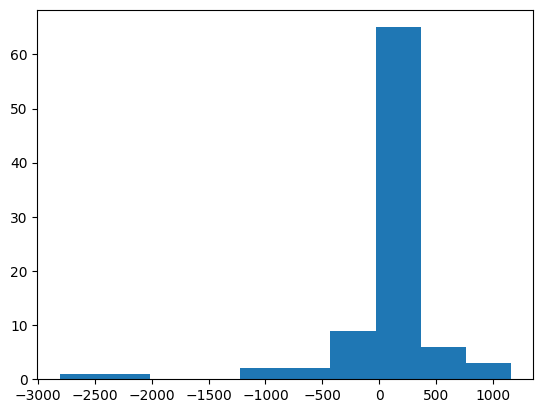

In [255]:
# <YOUR CODE HERE>
plt.hist((sm_ols.predict(X_test.loc[:, selected_features]) - y_test))

В целом, можно было и с самого начала сообразить, что данные какие-то специфические; а ещё можно было поглядеть на сущности `Omnibus` и `Prob(Omnibus)` в третьей табличке `summary` модели. Грубо говоря, они показывают степень нормальности остатков, и они тем нормальнее, чем меньше первое и чем больше второе (в идеале `Omnibus` = 0, `Prob(Omnibus)` = 1). Так вот, у нас всё плохо.

Ещё предлагаем нарисовать на одном графике гистограммы таргетов и предсказаний модели. Вы сразу увидите, что предсказаний распределены совсем не так, как истинные таргеты.

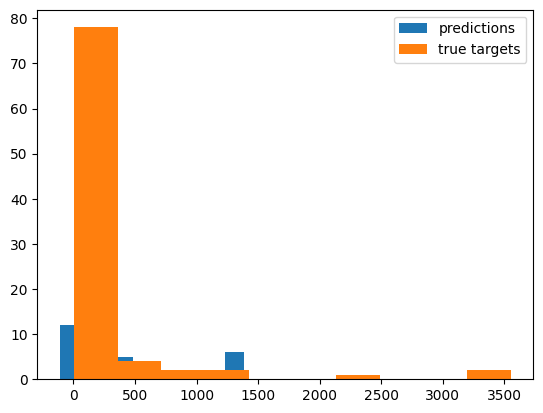

In [257]:
# <YOUR CODE HERE>
plt.hist(sm_ols.predict(X_test.loc[:, selected_features]), label="predictions")
plt.hist(y_test, label="true targets")
plt.legend()
plt.show()

В целом, наши таргеты принимают только целые значения, а их распределение больше похоже на распределение Пуассона

$$P(\xi = k) = \frac{\lambda^k}{k!}e^{-\lambda},$$

чем на нормальное, поэтому есть смысл попробовать пуассоновскую регрессию. Это один из разновидностей GLM (обобщённых линейных моделей). Напомним, в чём суть. В обычной линейной регрессии мы предполагаем, что $y \vert x$ имеет нормальное распределение $\mathcal{N}(\langle x, w\rangle, \sigma^2)$ (для некоторого $\sigma^2$), и это позволяет нам записать предсказание в виде:

$$\mathbb{E}(y|x) = \langle x, w\rangle$$

Но на самом деле мы можем выбирать и более сложные модели. Например, можно предположить, что $y\vert x$ имеет распределение Пуассона с параметром $\lambda = \langle x, w\rangle$; тогда, как показано в учебнике, предсказание обобщённой линейной модели будет иметь вид

$$\mathbb{E}(y|x) = \exp(\langle x, w\rangle)$$

А чтобы вы получше разобрались, сейчас вам нужно будет

**5.** Напишите и сдайте в контест самописную пуассоновскую регрессию.

Несколько указаний:

1. Пуассоновская регрессия обучается с помощью минимизации функции потерь, в качестве которой здесь выступает минус логарифм правдоподобия. Так что начните с того, что выпишите этот самый логарифм.
2. Минимизацию вам нужно будет организовать с помощью стохастического градиентного спуска с momentum'ом. Более подробно про momentum вы можете прочитать в главе учебника про оптимизацию в ML. А ещё рекомендуем заглянуть [вот на эту страничку](https://distill.pub/2017/momentum/). Там можно найти визуализацию.
3. Сама по себе пуассоновская регрессия не содержит никаких свободных членов. Если вы хотите, чтобы он был, нужно заранее добавлять к $X$ столбец из единиц. Внутри класса, который вы сдаёте в контест, добавлять единички не надо.
4. Написать класс не так сложно, а вот запустить модель, чтобы она работала, не всегда будет просто. Градиентный спуск будет сходиться нестабильно. Вам нужно будет подбирать параметр `lr` и `momentum`, чтобы, с одной стороны, выходить из нуля, а с другой, не уходить в бесконечность. `Momentum` немного поможет со стабильностью, но всё равно на исходных данных вы вряд ли заведёте модель. Поэтому для тестирования (а) примените `StandardScaler`, он сильно улучшит сходимость, и (б) ограничьтесь фичами, которые нашли с помощью AIC. Не бойтесь маленьких `lr`. Значения в районе `1e-7` — это ок.

In [492]:
import numpy as np
from sklearn.base import RegressorMixin


class SGDPoissonRegression(RegressorMixin):
    def __init__(self, lr=0.01, momentum=1, delta_converged=1e-3, max_steps=1000, batch_size=64):
        self.lr = lr
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size
        self.momentum = momentum

        self.W = None

    def fit(self, X, Y):
        '''
        X: numpy.ndarray (n_samples, n_features)
        Y: numpy,ndarray (n_samples.)
        '''
        self.W = np.ones((X.shape[1], 1)).ravel() / 1000
        self.grad_w = np.ones((X.shape[1], 1)).ravel()
        ## <YOUR CODE HERE>
        for e in range(self.max_steps):
            shuffled_indices = np.random.permutation(X.shape[0])
            self.X_shuffled = X[shuffled_indices]
            self.Y_shuffled = Y[shuffled_indices]
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = self.X_shuffled[i:i+self.batch_size]
                y_batch = self.Y_shuffled[i:i+self.batch_size]

                err = y_batch - np.ravel(np.exp(X_batch @ self.W.T))
                #print(err)
                self.grad_w  =  self.lr * (np.full(self.W.shape, self.batch_size).ravel() - (np.ones((X.shape[1], 1)).ravel() / self.W) * np.sum(err, axis=0)) - self.momentum * (-self.grad_w)
                if np.linalg.norm(self.grad_w) < self.delta_converged:
                    return self
                self.W -= self.grad_w
        return self

    def predict(self, X):
        '''
        X: numpy.ndarray (n_samples, n_features)
        returns: numpy.ndarray (n_samples,)
        '''
        ## <YOUR CODE HERE>
        return np.ravel(np.exp(X @ self.W.T))

Попробуйте запустить следующий пример. Если он не упал и выдал похожую картинку, то вы на верном пути

In [493]:
from scipy.stats import poisson

N = 200
D = 2
pathetic_X = np.random.rand(N, D)* 10
w = np.random.rand(D) * 1
pathetic_Y = (pathetic_X.dot(w) + np.random.randn(N)*0.05)

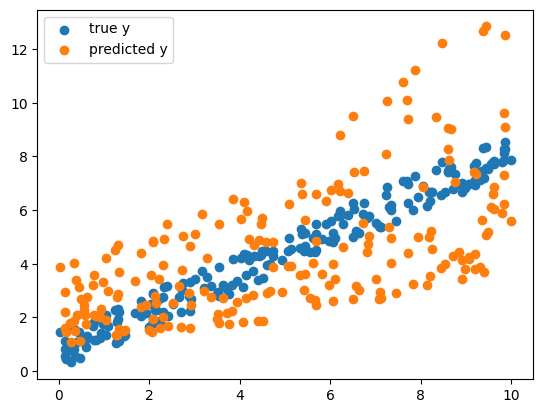

In [494]:
cclf = SGDPoissonRegression(lr=1e-6, batch_size=N, max_steps=1000, momentum=0.5)
cclf.fit(pathetic_X, pathetic_Y)

plt.scatter(pathetic_X[:,0], pathetic_Y, label='true y')
plt.scatter(pathetic_X[:,0], cclf.predict(pathetic_X), label='predicted y')
plt.legend()

А теперь попробуйте натравить вашу самописную пуассоновскую регрессию на датасет. Не забудьте про `StandardScaler` и про то, что мы берём только отобранные с помощью AIC фичи. Какое получилось качество? Нарисуйте гистограммы истинных и предсказанных таргетов. Стало ли распределение предсказаний похожим на предсказание истинных таргетов?

In [508]:
# <YOUR CODE HERE>
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train[selected_features])
y_train_scaled = StandardScaler().fit_transform(y_train.reshape(-1, 1)).ravel()
X_test_scaled = StandardScaler().fit_transform(X_test[selected_features])
y_test_scaled = StandardScaler().fit_transform(y_test.reshape(-1, 1)).ravel()
clf = SGDPoissonRegression(lr=1e-7, batch_size=200, max_steps=1000, momentum=0.1).fit(X_train_scaled, y_train_scaled)
clf_pred = clf.predict(X_test_scaled)
root_mean_squared_error(y_test_scaled, clf_pred)

1.5468508302654707

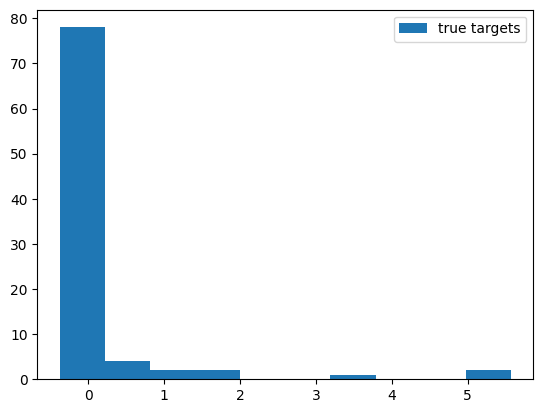

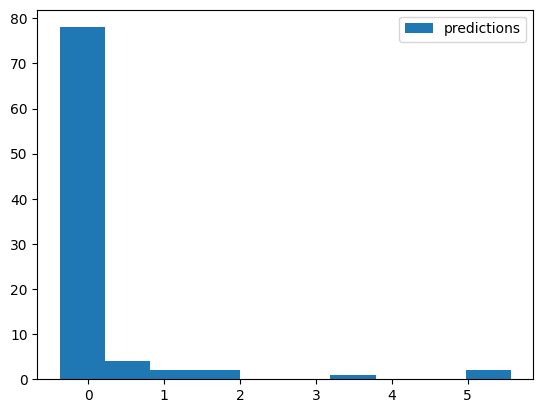

In [510]:
plt.hist(y_test_scaled, label="true targets")
plt.legend()
plt.show()
plt.hist(y_test_scaled, label="predictions")
plt.legend()
plt.show()

Надеемся, что теперь пуассоновская регрессия стала для вас чем-то чуть менее загадочным. Но применять мы будем реализацию из `statsmodels` (`statsmodels.api.Poisson`), потому что у неё есть всякие дополнительные возможности, которые вряд ли можно быстро закодить самостоятельно.

Библиотечная модель обучается с помощью методов второго порядка, а не с помощью SGD, и поэтому более стабильна, но на полном исходном датасете (со всеми признаками) завести её у вас может не выйти (оптимизационный процесс разойдётся). Поэтому давайте обучим на тех признаках, которые мы отобрали с помощью AIC, только без `StandardScaler`.

**6.** Обучите модель, отправьте в Контест полученные на тестовой выборке предсказания. Нужно ввести округлённое до целого значение метрики RMSE на тесте для библиотечной модели пуассоновской регрессии.

С помощью `summary` проверьте, будут ли признаки статзначимы (сейчас не будем подробно вникать в то, какие именно статистические тесты там используются). Вычислите `RMSE` и `MAPE` на тестовой выборке. Получилось ли повысить качество модели? Нарисуйте гистограммы истинных и предсказанных таргетов. Стали ли они более похожими?

In [548]:
sm_pois = sm.Poisson(y_train, np.array(X_train[selected_features], dtype=np.float64)).fit()
root_mean_squared_error(y_test, sm_pois.predict(np.array(X_test[selected_features], dtype=np.float64)))

Optimization terminated successfully.
         Current function value: 109.615694
         Iterations 12


453.1458207122366

# 2. Классификация

В этом разделе мы будем использовать синтетический датасет, в котором всё умеренно непросто: информативных фичей мало, много мусорных, имеет место дисбаланс классов (класса 1 в четыре раза меньше, чем класса 0). И всё же мы постараемся с ним сделать что-нибудь хорошее.

In [1]:
from sklearn.datasets import make_classification
X_light, y_light = make_classification(n_samples=1000, n_features=200,
                                       n_informative=2, n_redundant=50, n_repeated=0, n_classes=2,
                                       n_clusters_per_class=2, weights=(0.8,0.2), random_state=42)

In [2]:
from sklearn.model_selection import train_test_split

X_light_train, X_light_test, y_light_train, y_light_test =\
    train_test_split(X_light, y_light, test_size=0.5, random_state=142, stratify=y_light)

## 2.0. Предсказание вероятностей

Вероятностные модели классификации обычно имеют вид

$$P(y = c| x, w),$$

где $c$ — классы, $w$ — обучаемые параметры классификатора. То есть такая модель предсказывает вероятности классов (или по крайней мере делает вид, что предсказывает). И заметим для начала, что предсказание вероятностей — это совсем даже не бесполезное дело.

Хорошим примером является страхование. Чтобы рассчитать математическое ожидание затрат на лечение клиента (и сумму, которую с этого клиента стоит потребовать за страховку), страховая компания может захотеть получить в качестве результата работы модели непосредственно вероятность того, что у человека, не страдающего от заболевания, оно разовьётся в течение скольких-то лет.

Популярной метрикой оценки качества предсказания вероятностей является бинарная кросс-энтропия (она же logloss) между предсказанными вероятностями и истинными метками классов:

$$\text{crossentropy}(y, p) = -\frac{1}{N}\sum_{i=1}^N\left[y_i\log(p_i) + (1-y_i)\log(1-p_i)\right]$$

Заметим, что если бы нам были известны истинные вероятности, мы могли бы использовать хоть MSE, но, увы, обычно мы знаем только метки классов.

**Предсказание вероятностей в sklearn**. В классификаторах из библиотеки `sklearn` за предсказание вероятностей отвечает метод `predict_proba`. Он обычно возвращает матрицу размера `(n_samples, n_classes)`, у которой i-м столбце стоят вероятности i-го класса. Способ предсказания вероятностей, вообще говоря, разных для разных типов классификаторов, порой заставить классификатор предсказвать вероятности нетривиально. Но вот для логистической регрессии  всё максимально просто:

$$P(y = 1|x, w) = \sigma(\langle x,w \rangle)$$

## 2.1. Калибровка

Прежде, чем приступать к этой части задания, очень рекомендуем вам прочитать раздел "Как оценивать вероятности" ШАДовского учебника по ML.

Несмотря на то, что мы хотим предсказывать вероятности, истинных вероятностей мы не знаем, а при обучении у нас в качестве таргетов выступают метки классов. Возникает вопрос: а правда ли мы корректно предсказываем вероятности?

Найдутся люди, которые скажут, что логистическая регрессия всегда корректно предсказывает вероятности: ведь если

$$\mathcal{L}(y, \widehat{y}) = -y\log{\widehat{y}} - (1 - y_i)\log(1 - \widehat{y}),$$

то

$$arg\min_{\widehat{y}}\mathbb{E}(\mathcal{L}(y, \widehat{y})\mid x) = \mathbb{P}(y = 1\mid x)$$

Но мы сейчас обсуждаем жизнь, а не условные матожидания. А в жизни корректное предсказание вероятности означает, что предсказанная вероятность примерно равна доле элементов нужного класса в окрестности. И логистическая регрессия в этом смысле может вести себя сколь угодно плохо.

Давайте посмотрим, что с предсказанием вероятностей у нашей модели. В sklearn для этого есть специальный инструмент - калибровочная кривая (calibration_curve), а в свежих версиях добавился ещё CalibrationDisplay (но, кажется, если у вас Windows, то до вас эта версия ещё не доехала). Идея калибровочной кривой следующая:

- разобьём значения предсказанных вероятностей, скажем, на 10 равномерных бинов: (0,0.1), (0.1, 0.2) и так далее;
- для каждого бина посчитаем среднее значение метки класса;
- сравним это среднее значение со средним значением таргета в бине. Если всё хорошо, то они должны быть равны: в бине предсказывается примерно такая же вероятность, как и должна быть. А вот если среднее значение таргета другое, то у нас проблемы.

Для хорошо калиброванной модели калибровочная кривая должна примерно совпадать с диагональю единичного квадрата. Посторение кривой, конечно же, делается на валидационной выборке, как и любая другая оценка качества модели.

Разберитесь, как работает `sklearn.calibration.calibration_curve` или `sklearn.calibration.CalibrationDisplay`. Постройте что-нибудь из этого для вашего классификатора (возьмите разбиение на 10 бинов). Хорошо ли калибрована наша модель? О каких проблемах сообщает калибровочная кривая?

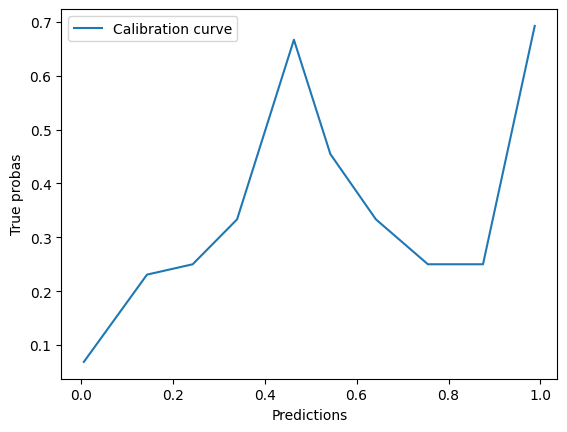

In [7]:
# <YOUR CODE HERE>
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_light_train, y_light_train)
y_pred = lr.predict_proba(X_light_test)[:,1]
prob_true, prob_pred = calibration_curve(y_light_test, y_pred, n_bins=10)
plt.plot(prob_pred, prob_true, label="Calibration curve")
plt.xlabel("Predictions")
plt.ylabel("True probas")
plt.legend()
plt.show()

Как вы уже поняли, калибровочная кривая имеет довольно патологический вид.

Попробуем исправить проблемы с помощью калибровки классификатора. Методы калибровки бывают разными; самые известные — это **калибровка Платта** и **изотоническая регрессия**. Прочитать о них вы можете в главе про оценивание вероятностей, а здесь вам предстоит реализовать калибратор с использованием изотонической регрессии. Более точное ТЗ:

- Ваша модель должна уметь работать и с `pandas.DataFrame`, и с `np.ndarray`.
- Калибратор — это класс классификатора. У него будет точно такой же интерфейс предсказания, как и у любого другого классификатора, а вот начинка немного другая. Для простоты мы будем делать калибратор только для бинарной классификации.
- Вообще говоря, калибратор может учиться поверх любого классификатора `base_estimator`, у которого есть метод `predict_proba`.
- Методология его работы будет чем-то напоминать кросс-валидацию. А именно, он делит обучающую выборку на К фолдов и К раз обучает `base_estimator` на (К-1) фолде. Далее, на оставшемся одном фолде обучается изотоническая регрессия `sklearn.isotonic.IsotonicRegression` (какие у неё данные и таргет — вам нужно будет самим разобраться, почитав главу или посмотрев соответствующую лекцию). Тем самым, у вас на руках оказывается К обученных пайплайнов `base_estimator` + изотоническая регрессия. При предсказании вероятности ваш класс будет усреднять предсказания вероятностей этих К пайплайнов.
- Подробностями кросс-валидации будет управлять параметр `cv`. Если его значение `None`, вы должны брать 5 фолдов. Если `cv` — целое число (ну, или целый `float`), то вы должны брать соответствующее число фолдов. Также ваш класс должен обязательно поддерживать передачу в качестве параметра `cv` конкретного разбиения на фолды (массив массивов: наборы индексов для фолдов). Вы можете считать, что индексы — это просто номера строк (`iloc` в случае `pd.DataFrame`, просто индексы в случае `np.ndarray`).
- Предсказание класса будем делать по правилу `class = [p > 0.5]`.
- Обратите внимание на параметр `out_of_bounds` изотонической регрессии. Ему надо указать правильное значение. Подсказка: если у вас всё падает при попытке посчитать метрику на предсказаниях, то вы указали неправильное значение.
- Убедитесь, что на разных фолдах вы учите независимые копии базовой модели. В этом вам может помочь `sklearn.base.clone`.

**7.** Загрузите ваш калибратор в контест.

In [3]:
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold

class IsotonicallyCalibratedModel(ClassifierMixin):
    def __init__(self, base_estimator=None, cv=None):
        # Your code here
        self.base_estimator = base_estimator
        self.n_folds = 5
        self.split_indices = None
        if type(cv) is int or type(cv) is float:
            self.n_folds = int(cv)
        else:
            self.split_indices = cv

    def fit(self, X=None, y=None):
        '''
        X :       numpy.ndarray or pd.DataFrame (n_samples, n_features)
        y :       numpy.ndarray or pd.DataFrame (n_samples,)
        '''
        # Your code here
        self.pipelines = []
        
        if self.split_indices:
            kfsplit = []
            for indices in self.split_indices:
                all_indices = np.arange(X.shape[0])
                remaining_indices = np.setdiff1d(all_indices, indices)
                kfsplit.append((remaining_indices, indices))
        else:
            kf = KFold(n_splits=self.n_folds)
            kfsplit = kf.split(X)

        
        for train_index, test_index in kfsplit:
            if type(X) is np.ndarray:
                X_train, X_test = X[train_index], X[test_index]
            if type(y) is np.ndarray:
                y_train, y_test = y[train_index], y[test_index]
            if type(X) is pd.core.frame.DataFrame:
                X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            if type(y) is pd.core.frame.DataFrame or type(y) is pd.core.series.Series:
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model = clone(self.base_estimator).fit(X_train, y_train)
            pred = model.predict_proba(X_test)[:,1]
            isoreg = IsotonicRegression(out_of_bounds='clip').fit(pred, y_test)
            self.pipelines.append([model, isoreg])

        return self

    def predict_proba(self, X=None):
        '''
        X :       numpy.ndarray or pd.DataFrame (n_samples, n_features)
        returns : numpy.ndarray (n_samples, 2)
        (column 0 - probability of class 0; column 1 - probability of class 1)
        '''
        # Your code here
        probas = np.zeros((X.shape[0], 2))
        for pipe in self.pipelines:
            model = pipe[0]
            isoreg = pipe[1]
            pred = model.predict_proba(X)[:,1]
            isoreg_pred = isoreg.predict(pred)
            isoreg_pred_neg = np.ones(isoreg_pred.shape) - isoreg_pred
            probas = probas + np.column_stack([isoreg_pred_neg, isoreg_pred])
        return probas / len(self.pipelines)

    def predict(self, X=None):
        '''
        X :       numpy.ndarray or pd.DataFrame (n_samples, n_features)
        returns : numpy.ndarray (n_samples,)
        '''
        # Your code here
        return np.array(self.predict_proba(X) > 0.5, dtype=np.int64)[:,0]

Нелишне, конечно, уметь использовать и готовые калибраторы, а именно `sklearn.calibration.CalibratedClassifierCV`. В нём реализованы и калибровка Платта, и изотоническая регрессия. Его интерфейс (равно как и принцип работы) очень похож на интерфейс того класса, который вы только что реализовали сами. Но у него есть и другой, тоже весьма ценный режим работы: он может использоваться поверх уже обученного классификатора (если указать `cv="prefit"`).

Нарисуйте на одном графике калибровочные кривые для логистической регрессии:

- не откалиброванной;
- калиброванной с помощью самописного класса;
- откалиброванной с помощью CalibratedClassifierCV(method='isotonic'),
- откалиброванной с помощью CalibratedClassifierCV(method='sigmoid').

Везде укажите `cv=5` (НЕ `prefit`). Распечатайте `log_loss` и `brier_score_loss` для каждого из библиотечных классификаторов.

**8.** Загрузите полученные четыре числа в контест.

Получилось ли улучшить ситуацию с калибровкой вероятностей? А общее качество предсказания вероятностей?

0.4409357345988242
0.09514320482344789
0.43977184877347897
0.09505904857664116
0.32510949749271756
0.09713437142911717


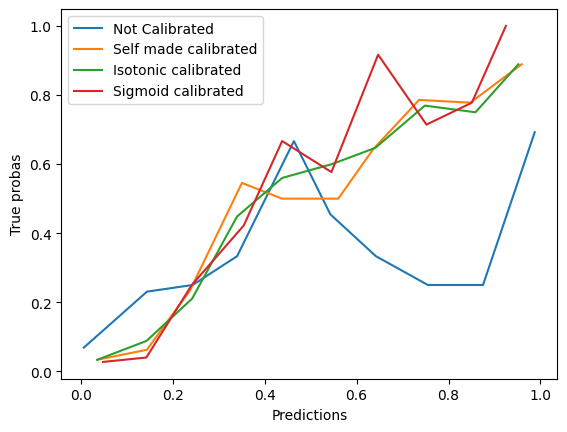

In [9]:
# <YOUR CODE HERE>
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, brier_score_loss

lr = LogisticRegression().fit(X_light_train, y_light_train)
y_pred_lr = lr.predict_proba(X_light_test)[:,1]
prob_true_lr, prob_pred_lr = calibration_curve(y_light_test, y_pred_lr, n_bins=10)

calibrated_clf_selfmade = IsotonicallyCalibratedModel(LogisticRegression(), cv=5).fit(X_light_train, y_light_train)
y_pred_selfmade = calibrated_clf_selfmade.predict_proba(X_light_test)[:,1]
prob_true_selfmade, prob_pred_selfmade = calibration_curve(y_light_test, y_pred_selfmade, n_bins=10)

calibrated_clf_iso = CalibratedClassifierCV(LogisticRegression(), cv=5, method='isotonic').fit(X_light_train, y_light_train)
y_pred_iso = calibrated_clf_iso.predict_proba(X_light_test)[:,1]
prob_true_iso, prob_pred_iso = calibration_curve(y_light_test, y_pred_iso, n_bins=10)

calibrated_clf_sigm = CalibratedClassifierCV(LogisticRegression(), cv=5, method='sigmoid').fit(X_light_train, y_light_train)
y_pred_sigm = calibrated_clf_sigm.predict_proba(X_light_test)[:,1]
prob_true_sigm, prob_pred_sigm = calibration_curve(y_light_test, y_pred_sigm, n_bins=10)

print(log_loss(y_light_test, y_pred_selfmade))
print(brier_score_loss(y_light_test, y_pred_selfmade))
print(log_loss(y_light_test, y_pred_iso))
print(brier_score_loss(y_light_test, y_pred_iso))
print(log_loss(y_light_test, y_pred_sigm))
print(brier_score_loss(y_light_test, y_pred_sigm))

plt.plot(prob_pred_lr, prob_true_lr, label="Not Calibrated")
plt.plot(prob_pred_selfmade, prob_true_selfmade, label="Self made calibrated")
plt.plot(prob_pred_iso, prob_true_iso, label="Isotonic calibrated")
plt.plot(prob_pred_sigm, prob_true_sigm, label="Sigmoid calibrated")
plt.xlabel("Predictions")
plt.ylabel("True probas")
plt.legend()
plt.show()

## 2.2. Робастная логистическая регрессия

Допустим, есть подозрение, что некоторые из истинных таргетов испорченные. Например, выяснилось, что при сборе данных был сбой. При этом мы не знаем, какие именно. Как быть?

Есть много способов бороться с этим. Например, каким-то образом найти и обезвредить проблемные таргеты (скажем, каким-нибудь методом удаления выбросов). Но мы поговорим о том, как это сделать с помощью модификации вероятностной модели.

Базовая модель логистической регрессии (с классами 0 и 1) имеет вид

$$P(y=1|x, w) = \sigma(\langle x, w \rangle)$$

или, что то же самое,

$$p(y|x, w) = \sigma(\langle x, w \rangle)^y(1 - \sigma(\langle x, w \rangle))^{1 - y}$$

То есть это распределение Бернулли с вероятностью успеха $\sigma(\langle x, w\rangle)$.

Представим теперь, что наша вероятностная модель - это не одно распределение, а _смесь_ двух:

- не зависящего от $x$ с вероятностью $\frac12$ и
- того самого с вероятностью $\sigma(\langle x, w\rangle)$

То есть с некоторой фиксированной вероятностью $\pi$ каждый таргет заменяется на случайное число, а, соответственно, с вероятностью $(1 - \pi)$ у нас модель логистической регрессии. Обозначим через $z$ _скрытую переменную_, которая равна 1, если таргет испорчен, и 0 иначе. Тогда вероятностная модель принимает вид:

$$p(y\mid x, w) = p(y\mid z = 1, x, w)p(z = 1) + p(y\mid z = 0, x, w)p(z = 0) =$$

$$= \pi \cdot \underbrace{\left(\frac12\right)^y\left(\frac12\right)^{1-y}}_{=\frac12} + (1 - \pi) \sigma(\langle x, w \rangle)^y(1 - \sigma(\langle x, w \rangle))^{1 - y}$$

Нашей задачей остаётся найти вектор весов $w$, но теперь нам надо ещё оценить вероятность $\pi$ и для каждого объекта выборки $(x_i, y_i)$ посчитать $z_i$. Есть несколько вариантов, как это сделать. Можно, в принципе, написать минус логарифм правдоподобия $-\sum_i\log p(y_i\mid x_i, w)$ и оптимизировать его с помощью SGD, но функция потерь сложная и завести оптимизацию так, чтобы она хорошо сходилась, будет не очень просто. Поэтому мы схитрим.

Если бы нам были доступна "степень надёжности" $q_i$ каждого объекта, то мы могли бы обучить логистическую регрессию с этими весами:

$$-\sum_{i=1}^Nq_i\left(\vphantom{\frac12}y_i\log\sigma(\langle x, w\rangle) + (1 - y_i)\log(1 - \sigma(\langle x, w\rangle))\right)\rightarrow\min_w$$

Тогда более "надёжные" объекты вносили бы более весомый вклад в процесс оптимизации. Кроме того, мы могли бы оценить вероятность $\pi$:

$$1-\pi = \frac1N\sum_iq_i$$

Оценить эту самую степень надёжности можно с помощью теоремы Байеса:

$$q_i = P(z_i = 0|y_i, x_i, w, \pi) = \frac{P(y_i|z_i = 0, x_i, \pi, w)P(z_i = 0|\pi)}{P(y_i|x_i,\pi,w)} =$$

Итак, предлагается восстанавливать модель, чередуя два вида шагов:

**E-шаг**. Вычисление $q_i$

**M-шаг**. Оптимизация $w$ и оценка $\pi$.

То, что мы получили сейчас из очень наивных соображений, является частным случаем _ЕМ-алгоритма_ для смеси двух распределений Бернулли. Пока мы не будем доказывать, почему это работает; с ЕМ-алгоритмом в общем виде вы познакомитесь в следующем семестре.

**9.** Напишите класс BernoulliMixtureClassifier, который реализует описанную выше идею, и сдайте его в Контест.

Небольшая модификация:

- поскольку у нас в любом случае длинный итерационный процесс, нет нужды каждый раз до конца учить логистическую регрессию. На M-шаге достаточно, например, делать один шаг градиентного спуска (или даже стохастического градиентного спуска). Предлагаем вам именно так и сделать (но не SGD, а обычный GD). Параметр `lr` — это как раз длина шага градиентного спуска.
- для простоты не будем учитывать bias.

Вообще говоря, веса `W` вы можете инициализировать как угодно, но результат может зависит от инициализации, поэтому, пожалуйста, инициализируйте их нулями.

In [112]:
class BernoulliMixtureClassifier(ClassifierMixin):
    def __init__(self, lr=0.001, delta_converged=1e-3, max_steps=1000):
        '''
        lr - learning rate of gradient descent at M step
        delta_converged - stop when np.linalg.norm(self.W - W_new) < self.delta_converged
        max_steps - max number of EM iterations
        '''
        self.lr = lr
        self.max_steps = max_steps
        self.delta_converged = delta_converged

        self.W = None
        self.pi = None

    def fit(self, X, Y):
        '''
        X :       numpy.ndarray (n_samples, n_features)
        Y :       numpy.ndarray (n_samples,)
        '''
        ## <YOUR CODE HERE>
        self.W = np.zeros(X.shape[1])
        self.W_prev = np.ones(X.shape[1])
        self.pi = 0.5
        for _ in range(self.max_steps):
            sigmoid_vals = self.sigmoid(X @ self.W)
            q = (1 - self.pi) * np.power(sigmoid_vals, Y) @ np.power((1 - sigmoid_vals), (1 - Y)) / \
                (0.5 * self.pi + (1 - self.pi) * np.power(sigmoid_vals, Y) @ ((1 - np.power(sigmoid_vals, 1 - Y))))
            self.grad_w = np.sum(q * (sigmoid_vals - Y)[:, np.newaxis] * X, axis=0)
            self.pi = 1 - np.mean(q)
            if np.linalg.norm(self.W - self.W_prev) < self.delta_converged:
                break
            self.W -= self.lr * self.grad_w / X.shape[0]
            self.W_prev = np.copy(self.W)
        return self
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def predict_proba(self, X):
        '''
        X :       numpy.ndarray (n_samples, n_features)
        returns : numpy.ndarray (n_samples, 2)
        (column 0 - probability of class 0; column 1 - probability of class 1)
        '''
        ## <YOUR CODE HERE>
        sigmoid_vals = self.sigmoid(X @ self.W)
        probas = (np.ones(sigmoid_vals.shape) - self.pi) * sigmoid_vals + 0.5 * self.pi
        return np.column_stack([1 - probas, probas])
        

    def predict(self, X):
        '''
        X :       numpy.ndarray (n_samples, n_features)
        returns : numpy.ndarray (n_samples,)
        '''
        return np.argmax(self.predict_proba(X), axis=1)

Несмотря на то, что мы придумали этот классификатор для борьбы с порчей таргета, нелишне посмотреть и как он работает на обычных данных. Сравните его с не регуляризованной логистической регрессией (вы же понимаете, каким надо установить значение параметра `C` в `LogisticRegression`, чтобы отключить регуляризацию?):

- в деле предсказания класса по метрике F1 (sklearn.metrics.f1_score)
- в деле предсказания вероятностей по метрике log_loss

Сравнивать, конечно, надо на тестовой выборке.

Получилось ли лучше?

In [129]:
# <YOUR CODE HERE>
from sklearn.metrics import f1_score
bmc = BernoulliMixtureClassifier().fit(X_light_train, y_light_train)
bmc_pred = (bmc.predict(X_light_test))

lr = LogisticRegression(penalty=None).fit(X_light_train, y_light_train)
lr_pred = (lr.predict(X_light_test))

print("F1 Score for self made bernulli classifier:", f1_score(y_light_test, bmc_pred))
print("F1 Score for sklearn logistic regression:", f1_score(y_light_test, lr_pred))

F1 Score for self made bernulli classifier: 0.7563025210084033
F1 Score for sklearn logistic regression: 0.5800865800865801


Теперь давайте всё-таки разберёмся, помогает ли эта модель бороться с ошибками в таргете. Проведите эксперименты:

- для $\pi\in\{0, 0.1, 0.2, \ldots, 0.9\}$ замените каждый $y_i$ из обучающей выборке с вероятностью $\pi$ на случайный.
- обучите на полученном датасете не регуляризованную логистическую регрессию и модель со смесью распределений.
- нарисуйте на одном графике зависимости F1 меры моделей на тестовой выборке от $\pi$.

Поскольку всё случайно, графики будут меняться от запуска к запуску, и не всегда модель со смесью будет прямо стабильно лучше обычной, но вы вполне можете рассчитывать получить что-то такое:

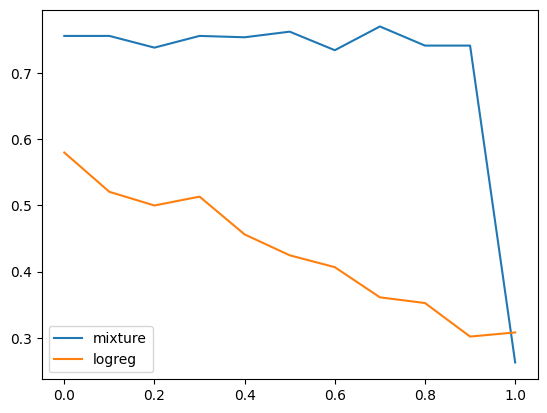

In [137]:
pi = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1_logreg = []
f1_mixture = []
for i in range(len(pi)):
    total_indices = np.arange(y_light_train.shape[0])
    num_indices = int(y_light_train.shape[0] * pi[i])
    random_indices = np.random.choice(total_indices, size=num_indices, replace=False)
    random_numbers = np.random.randint(2, size=num_indices)
    
    y_train_randomized = y_light_train.copy()
    y_train_randomized[random_indices] = random_numbers
    
    bmc = BernoulliMixtureClassifier().fit(X_light_train, y_train_randomized)
    bmc_pred = (bmc.predict(X_light_test))
    f1_mixture.append(f1_score(y_light_test, bmc_pred))
    
    lr = LogisticRegression(penalty=None, max_iter=1000).fit(X_light_train, y_train_randomized)
    lr_pred = (lr.predict(X_light_test))
    f1_logreg.append(f1_score(y_light_test, lr_pred))
plt.plot(pi, f1_mixture, label="mixture")
plt.plot(pi, f1_logreg, label="logreg")
plt.legend()
plt.show()

## 2.3. А способна ли на такое инженерная модель?

Только что мы увидели, что практические соображения (в частности, о порче таргетов) можно запаковать в вероятностную модель и улучшить этим ваши предсказания. А как быть, если презираешь вероятности и любишь обычные инженерные модели?

Оказывается, там тоже можно что-то сделать. И самое первое, что приходит в голову - это изменить функцию потерь. Вы уже, наверное, слышали, что в задаче регрессии при наличии выбросов стоит использовать MAE вместо MSE. В задачах классификации тоже можно делать интересные вещи. Вот [пример не такой уж и давней статьи](https://arxiv.org/pdf/1906.03361.pdf), в которой предлагается модификация функции потерь для повышения робастности логистической регрессии.

Идея, которая стоит за такими модификациями, проста. Допустим, классы называются $(-1)$ и $(+1)$. Тогда любая функция потерь линейного классификатора является функцией от _отступа_ $M_i = y_i\langle x_i, w\rangle$. Положительные отступы - это хорошо (знаки $y_i$ и $\langle x_i, w\rangle$ одинаковы, класс предсказывается верно), а отрицательные - плохо (знаки разные, класс предсказывается неверно). За отрицательные отступы надо штрафовать, а за положительные не стоит.

И вот логистическая функция потерь имеет вид

$$\mathcal{L}(M) = \log(1 + \exp(-M))$$

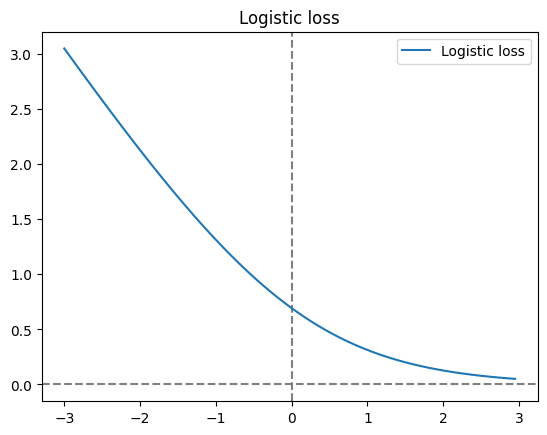

In [138]:
xx = np.arange(-3, 3, 0.05)
yy = np.log(1 + np.exp(-xx))

plt.title('Logistic loss')
plt.axvline(x=0, linestyle='--', color='grey')
plt.axhline(y=0, linestyle='--', color='grey')
plt.plot(xx, yy, label='Logistic loss')
plt.legend()

Видно, что чем больше по модулю отрицательный отступ, тем суровее его штрафует лосс (и этим свойством, кстати, обладают многие функции потерь классификации). Получается, что лосс может переобучаться под выбросы. В статье же предлагается лосс, у которого слева есть горизонтальная асимптота.

## Байесовский подход к логистической регрессии

Сгенерируем небольшой синтетический датасет

In [139]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=np.array([[-1,2], [2, 4.5]]),
                  cluster_std=1.0, random_state=42)
X1, y1 = make_blobs(n_samples=100, n_features=2, centers=np.array([[3,1],[-1,6.5]]),
                    cluster_std=1.0, random_state=42)
X2, y2 = make_blobs(n_samples=100, n_features=2, centers=np.array([[5,3],[4,7.5]]),
                    cluster_std=1.0, random_state=42)
print(y.shape, y1.shape)
X = np.vstack((X, X1, X2))
X = np.hstack((X, np.ones((X.shape[0],1))))
y = np.concatenate((y, y1, y2))

(100,) (100,)


In [140]:
from sklearn.linear_model import LogisticRegression

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def logsigmoid(x):
    return -np.log(1 + np.exp(-x))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=144
)

clf = LogisticRegression(fit_intercept=False, C=1e+10)
clf.fit(X_train, y_train)
print(clf.coef_)

[[ -0.3557291    4.48006094 -15.922861  ]]


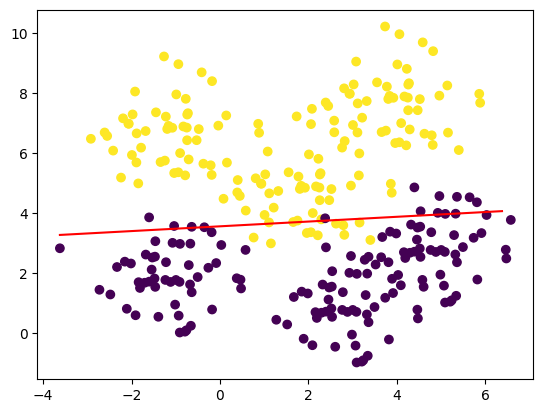

In [141]:
plt.scatter(X[:,0], X[:,1], c=y)

xx = np.arange(X[:,0].min(), X[:,0].max(), 1)
plt.plot(xx, (-clf.coef_[0][0]*xx - clf.coef_[0][2])/clf.coef_[0][1], color='red')

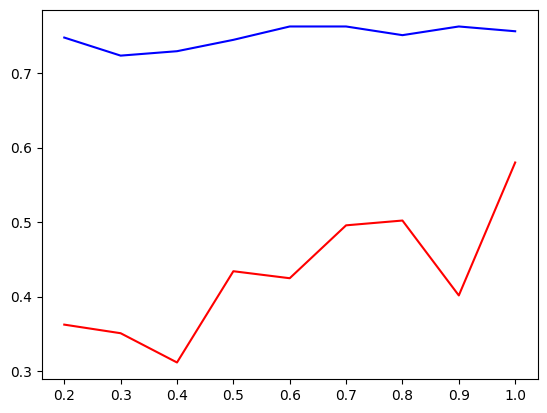

In [144]:
f1s = []

bad_ratios = np.arange(1, 0.1, -0.1)
for bad_ratio in bad_ratios:
    bad_mask = np.random.choice(2, y_light_train.shape[0], p=[bad_ratio, 1 - bad_ratio])
    y_train_bad = bad_mask * np.random.choice(2, y_light_train.shape[0]) + (1 - bad_mask) * y_light_train
    clf = LogisticRegression(C=1e+10)
    clf.fit(X_light_train, y_train_bad)
    pred = clf.predict(X_light_test)
    f1s.append(f1_score(y_light_test, pred))

plt.plot(bad_ratios, f1s, color='red')

f1s = []

for bad_ratio in bad_ratios:
    bad_mask = np.random.choice(2, y_light_train.shape[0], p=[bad_ratio, 1 - bad_ratio])
    y_train_bad = bad_mask * np.random.choice(2, y_light_train.shape[0]) + (1 - bad_mask) * y_light_train
    clf = BernoulliMixtureClassifier(lr=0.001)
    clf.fit(X_light_train, y_train_bad)
    pred = clf.predict(X_light_test)
    f1s.append(f1_score(y_light_test, pred))

plt.plot(bad_ratios, f1s, color='blue')

In [145]:
y_train_bad

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,

In [146]:
y_train

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0])

Оценим обоснованность с помощью Монте-Карло:

$$\int p(y|w,X)p(w)dw = \mathbb{E}_{w\sim p(w)}p(y|w,X)$$

In [147]:
w_sampled = np.random.randn(20000,3)
marginal_likelihood = np.mean([
    np.exp(logsigmoid(y*X.dot(w)).sum())
             for w in w_sampled])
print(marginal_likelihood)

8.178485000434401e-47


Эта оценка поможет нам вычислить апостериорную плотность

In [148]:
ww1 = np.arange(-40,40,2)
ww2 = np.arange(-40,40,2)

logaposteriori = (
    np.array([[
        logsigmoid(y*(X.dot(np.array([w1, w2, -4.66482286])))).sum(axis=0) +
        st.multivariate_normal.logpdf(np.array([w1, w2, -4.66482286]),
                                      mean=np.zeros((3,)), cov=np.eye(3))
        for w1 in ww1.flatten()] for w2 in ww2.flatten()
    ])
          - np.log(marginal_likelihood)
)

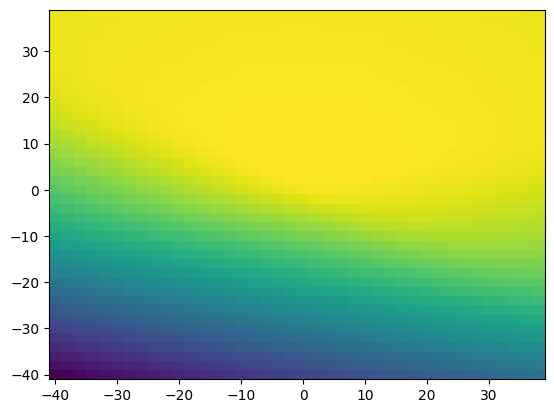

In [149]:
plt.pcolormesh(ww1, ww2, logaposteriori)

Проблема, однако же, в том, что даже зная плотность, мы не очень понимаем, как из неё генерировать (да и, прямо скажем, будь размерность пространства признаков или число объектов побольше, мы бы убились или Монте-Карло не сошлось бы). Поэтому мы используем приближение Лапласа, чтобы заменить неизвестное апостериорное распределение многомерным нормальным.

In [151]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X, y)

s_diag = sigmoid(y*X.dot(clf.coef_))

marginal_likelihood_estimate = (
    (2*np.pi)**(3/2) * (
        np.exp(logsigmoid(y*X.dot(clf.coef_)).sum() +
    st.multivariate_normal.logpdf(clf.coef_[0], mean=np.zeros((3,)), cov=np.eye(3))
          + 0)
    ) / np.sqrt(sla.det(X.T.dot(np.diag(s_diag*(1 - s_diag))).dot(X) + np.eye(3)))
)

print(marginal_likelihood_estimate)

6.7355184082057886e-71


In [152]:
logaposteriori_estimate = (
    np.array([[
        st.multivariate_normal.logpdf(np.array([w1, w2, -4.66482286]),
                                      mean=clf.coef_,
                                cov=sla.inv(X.T.dot(np.diag(s_diag*(1 - s_diag))).dot(X) + np.eye(3)))
        for w1 in ww1.flatten()] for w2 in ww2.flatten()
    ])
)

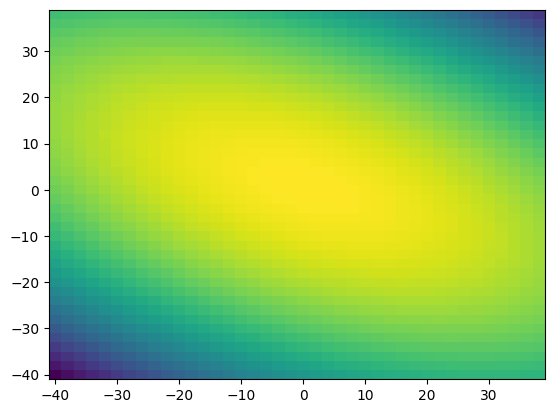

In [153]:
plt.pcolormesh(ww1, ww2, logaposteriori_estimate)

Поскольку исходное распределение было несимметричным, приблизить нормальным получилось лишь приблизительно, но хоть так. Посмотрим лучше, что за разделяющие прямые будут генерироваться из этого распределения:

In [154]:
sample_lines = st.multivariate_normal.rvs(mean=clf.coef_,
                           cov=sla.inv(X.T.dot(np.diag(s_diag*(1 - s_diag))).dot(X) + np.eye(3)),
                           size=10)

(-0.9875689146008928, 10.220169166589619)

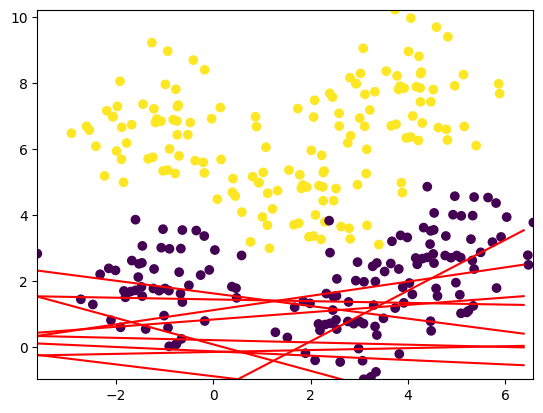

In [155]:
plt.scatter(X[:,0], X[:,1], c=y)

xx = np.arange(X[:,0].min(), X[:,0].max(), 1)

for sline in sample_lines:
    plt.plot(xx, (-sline[0]*xx - sline[2])/sline[1], color='red')

plt.xlim([X[:,0].min(), X[:,0].max()])
plt.ylim([X[:,1].min(), X[:,1].max()])

Видим, что получается достаточно неплохо. Ниже приведём ещё то, как выглядели бы насемплированные разделяющие прямые, если бы мы обучались только на 10 первых точках. Как и следовало ожидать, разнообразие куда выше:

In [156]:
k = 10
sample_lines = st.multivariate_normal.rvs(mean=clf.coef_,
        cov=sla.inv(X[:k,:].T.dot(np.diag(s_diag[:k]*(1 - s_diag[:k]))).dot(X[:k,:]) + np.eye(3)),
                           size=10)

(-0.9875689146008928, 10.220169166589619)

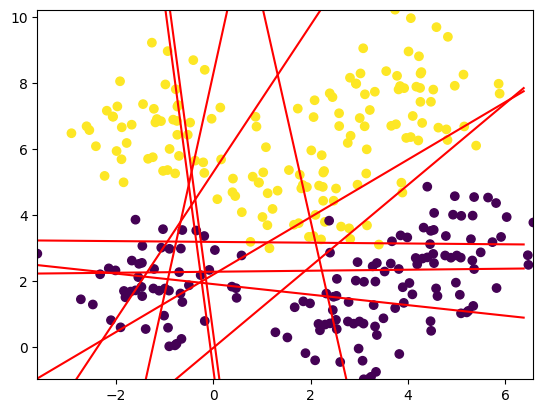

In [157]:
plt.scatter(X[:,0], X[:,1], c=y)

xx = np.arange(X[:,0].min(), X[:,0].max(), 1)

for sline in sample_lines:
    plt.plot(xx, (-sline[0]*xx - sline[2])/sline[1], color='red')

plt.xlim([X[:,0].min(), X[:,0].max()])
plt.ylim([X[:,1].min(), X[:,1].max()])